In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
!pip install celluloid
!pip install hdbscan

In [3]:
import sys, os
sys.path.append("../..")
sys.path.append("..")
sys.path.append(os.getcwd())
import re
import datetime

import math
import scipy

from matplotlib import pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
import seaborn as sns
sns.set()
sns.set(palette="bright")
sns.set_style("whitegrid")

from sklearn import linear_model
from cycler import cycler
from celluloid import Camera
from IPython.display import HTML

import importlib
import warnings
import numpy as np
import pandas as pd
import copy
import random
from tslib.src import tsUtils
from tslib.tests import testdata
from sklearn.cluster import KMeans, AgglomerativeClustering, AffinityPropagation, DBSCAN #For clustering
from sklearn.mixture import GaussianMixture #For GMM clustering
from filter_data import *
from load_and_clean import *
import hdbscan
%matplotlib inline

In [4]:
import warnings
warnings.filterwarnings('ignore')

## Pre-processing data

In [5]:
#global settings for graphs        
cc = (cycler(linestyle=['-', '--', '-.',':']) * cycler(color=list('brgcmyk')))
plt.rc('lines', linewidth=2)
plt.rc('axes', prop_cycle=cc)
plt.rcParams['figure.figsize'] = (8.0, 6.0)

plt.rcParams["animation.html"] = "html5"

size=14
params = {'legend.fontsize': 'large',
          'figure.figsize': (20,8),
          'axes.labelsize': size,
          'axes.titlesize': size,
          'xtick.labelsize': size*0.75,
          'ytick.labelsize': size*0.75,
          'axes.titlepad': 25}
plt.rcParams.update(params)
#plt.rcParams.update({'font.size': 14})

In [6]:
#Load and clean all raw data
#update_data()
us = load_clean('NYTimes US')
uscases, usdeaths, usstates = load_clean('NYTimes states')
uscounties_cases, uscounties_deaths, uscounties = load_clean('NYTimes counties')
global_cases, global_deaths = load_clean('JHU global')
us_covid_jhu_cases, us_covid_jhu_deaths = load_clean('JHU US')
mobility_data_apple, mobility_data_google, google_social = load_clean('mobility')
sd_data = load_clean('IHME intervention')
all_population, country_population, usstates_population, uscounties_population = load_clean('population')

uscases_pop_adjusted, usdeaths_pop_adjusted = create_population_adjusted_data(uscases, all_population), \
                                    create_population_adjusted_data(usdeaths, all_population, show_exception = True)
global_cases_pop_adjusted, global_deaths_pop_adjusted = create_population_adjusted_data(global_cases, all_population), \
                                    create_population_adjusted_data(global_deaths, all_population, show_exception = True)

uscounties_cases_pop_adjusted = create_population_adjusted_data(uscounties_cases, all_population, show_exception = True, county = True)
uscounties_deaths_pop_adjusted = create_population_adjusted_data(uscounties_deaths, all_population, county = True)

These countries/region do not have population data ['Virgin Islands']
These countries/region do not have population data ['Bahamas', 'Cabo Verde', 'Congo (Brazzaville)', 'Congo (Kinshasa)', "Cote d'Ivoire", 'Diamond Princess', 'Eswatini', 'Gambia', 'Holy See', 'Kyrgyzstan', 'North Macedonia', 'Saint Lucia', 'Saint Vincent and the Grenadines', 'Slovakia', 'Taiwan*', 'Syria', 'West Bank and Gaza', 'Saint Kitts and Nevis', 'Burma', 'MS Zaandam', 'Western Sahara']
These countries/region do not have population data ['Adjuntas-Puerto Rico', 'Aguada-Puerto Rico', 'Aguadilla-Puerto Rico', 'Aguas Buenas-Puerto Rico', 'Aibonito-Puerto Rico', 'Anasco-Puerto Rico', 'Anchorage-Alaska', 'Arecibo-Puerto Rico', 'Arroyo-Puerto Rico', 'Barceloneta-Puerto Rico', 'Barranquitas-Puerto Rico', 'Bayamon-Puerto Rico', 'Cabo Rojo-Puerto Rico', 'Caguas-Puerto Rico', 'Camuy-Puerto Rico', 'Canovanas-Puerto Rico', 'Carolina-Puerto Rico', 'Catano-Puerto Rico', 'Cayey-Puerto Rico', 'Ceiba-Puerto Rico', 'Ciales-Puerto

In [7]:
lemma = load_clean('lemma')

In [8]:
lemma_rt = lemma.copy()
lemma_rt['county']=lemma_rt['county'].apply(lambda n : n+'-California')
lemma_rt = lemma_rt.dropna().pivot(index='county', columns='date', values='median_rt')

In [12]:
lemma_rt[0:3]

date,2020-03-15,2020-03-16,2020-03-17,2020-03-18,2020-03-19,2020-03-20,2020-03-21,2020-03-22,2020-03-23,2020-03-24,...,2020-07-12,2020-07-13,2020-07-14,2020-07-15,2020-07-16,2020-07-17,2020-07-18,2020-07-19,2020-07-20,2020-07-21
county,,,,,,,,,,,,,,,,,,,,,
Alameda-California,NaN,1.31,1.25,1.17,1.09,1.03,0.99,0.97,0.95,0.94,...,0.95,0.94,0.94,0.94,0.94,0.94,0.94,0.94,0.94,0.94
Butte-California,1.60,1.55,1.50,1.43,1.35,1.28,1.22,1.17,1.14,1.12,...,1.43,1.42,1.42,1.42,1.41,1.41,1.41,1.41,1.41,1.41
Contra Costa-California,2.88,2.84,2.75,2.59,2.35,2.01,1.58,1.21,1.03,0.95,...,1.09,1.08,1.08,1.08,1.07,1.07,1.07,1.07,1.07,1.07


In [13]:
%%bigquery raw_ca_mobility
SELECT substr(sub_region_2,0,length(sub_region_2)-7)||'-California' AS county, date, 
retail_and_recreation_percent_change_from_baseline, residential_percent_change_from_baseline
FROM `bigquery-public-data.covid19_google_mobility.mobility_report` WHERE 
sub_region_1='California' AND sub_region_2 IS NOT NULL
AND date>='2020-03-08' AND date<='2020-06-18'
ORDER BY county, date

In [88]:
apple_ca_driving_mobility=mobility_data_apple[(mobility_data_apple['geo_type']=='county') & (mobility_data_apple['sub-region']=='California') & (mobility_data_apple['transportation_type']=='driving')]

In [14]:
google_ca_mobility = raw_ca_mobility.pivot(index='county', columns='date', values='retail_and_recreation_percent_change_from_baseline')
#google_ca_mobility = raw_ca_mobility.pivot(index='county', columns='date', values='residential_percent_change_from_baseline')

In [15]:
#Filter data 
# This part might be to split and explain
# This part might be to split and explain
t = 7

global_deaths_filtered = create_filtered_data(global_deaths, 500 )
#the last column of social distancing dataset is the last social distancing measure used by a location
educational_distancing = get_social_distancing(sd_data, sd_data.columns[-1])

all_data = pd.concat([global_deaths, usdeaths, uscounties_deaths], axis=1)  
all_data_daily = create_rolling_data(all_data, t)

all_data_cases = pd.concat([global_cases, uscases, uscounties_cases], axis=1) 
all_data_cases_daily = create_rolling_data(all_data_cases, t)

all_cases_data_pop = pd.concat([uscases_pop_adjusted,global_cases_pop_adjusted, uscounties_cases_pop_adjusted], axis = 1)
all_cases_data_pop_daily = create_rolling_data(all_cases_data_pop, t)

all_death_data_pop = pd.concat([usdeaths_pop_adjusted,global_deaths_pop_adjusted, uscounties_deaths_pop_adjusted], axis = 1)
all_death_data_pop_daily = create_rolling_data(all_death_data_pop, t)

_, daily_global, intervention_date_global = create_intervention_adjusted_data(global_deaths, educational_distancing, t)
_, daily_us, intervention_date_us = create_intervention_adjusted_data(usdeaths, educational_distancing, t)
_, daily_uscounties, intervention_date_uscounties = create_intervention_adjusted_data(uscounties_deaths, educational_distancing, t)

cases_intervention_adjusted, cases_intervention_adjusted_daily, intervention_date_case = create_intervention_adjusted_data(all_data_cases, educational_distancing, t)
deaths_intervention_adjusted, deaths_intervention_adjusted_daily, intervention_date_death = create_intervention_adjusted_data(all_data, educational_distancing, t)

all_cases_data_pop_adjusted, all_cases_data_pop_adjusted_daily, _ = create_intervention_adjusted_data(all_cases_data_pop, educational_distancing, t)
all_death_data_pop_adjusted, all_death_data_pop_adjusted_daily, _ = create_intervention_adjusted_data(all_death_data_pop, educational_distancing, t)

last date
Exceptions are []


### California mask counterfactual analysis

In [17]:
from datetime import datetime
start_day = '2020-03-08'
df = all_cases_data_pop[uscounties_cases_pop_adjusted.columns].loc[start_day:]
#df = all_cases_data_pop_daily[uscounties_cases_pop_adjusted.columns].loc[start_day:]

start_dt = datetime.strptime(start_day, "%Y-%m-%d")

start_rt_dt = datetime.strptime(lemma_rt.columns[0], "%Y-%m-%d")
print("R_t data starts: ", start_rt_dt)

ca_counties = list(uscounties.loc[uscounties.state == 'California'].county_state.unique())
ca_counties = list(set(ca_counties) - set(['Unknown-California']))

#exclude prison outbreaks
ca_counties = list(set(ca_counties) - set(['Kings-California', 'Santa Barbara-California', 
                                           'Marin-California', 'Riverside-California', 
                                           'San Bernardino-California']))

#Counties with a mandate by May 9, 2020
#Orange had one until June 11 so it's included although it's worth looking in the last week for change in trajectory
import numpy as np
cmd = [['Alameda-California','2020-04-22'], ['Contra Costa-California','2020-04-22'],
       ['Del Norte-California', '2020-04-02'], ['Humboldt-California', '2020-04-24'],
       ['Imperial-California', '2020-04-09'], ['Inyo-California', '2020-05-08'],
       ['Los Angeles-California', '2020-04-10'], 
       #['Marin-California', '2020-04-22'], 
       ['Mendocino-California', '2020-05-01'], ['Mono-California', '2020-04-13'], 
       ['Monterey-California', '2020-04-30'], ['Napa-California', '2020-05-07'], 
       ['Orange-California', '2020-04-24'], # note it wasn't in effect from June 11-18 
       ['Plumas-California', '2020-05-09'], 
       #['Riverside-California', '2020-04-06'], 
       ['San Benito-California', '2020-04-27'], 
       #['San Bernardino-California', '2020-04-08'], 
       ['San Diego-California', '2020-05-01'],
       ['San Francisco-California', '2020-04-22'], ['San Mateo-California', '2020-04-22'], 
       ['Santa Cruz-California', '2020-04-24'], ['Sierra-California', '2020-05-01'],
       ['Sonoma-California', '2020-04-17'], ['Yolo-California', '2020-04-24'], 
       ['Yuba-California', '2020-05-04']]
       
counties_mandated_dts = np.array(cmd)

counties_mandated = counties_mandated_dts[:,0]

counties_not_mandated = list(set(ca_counties) - set(counties_mandated))

df1 = df[df.columns[(df>10).any()]].copy()

counties_mandated = list(df1.columns[df1.columns.isin(counties_mandated)])
df1 = df[df.columns[(df>10).any()]].copy()

counties_not_mandated = list(df1.columns[df1.columns.isin(counties_not_mandated)])

#Since this data is based on counties with COVID cases and Mono county has had none it is not included in the analysis...
print("No. of counties with mask mandates: ", len(counties_mandated))
print("No. of counties without mask mandates: ", len(counties_not_mandated))
print(ca_counties)

R_t data starts:  2020-03-15 00:00:00
No. of counties with mask mandates:  22
No. of counties without mask mandates:  30
['Glenn-California', 'Siskiyou-California', 'Sierra-California', 'Mariposa-California', 'Orange-California', 'Contra Costa-California', 'Napa-California', 'Amador-California', 'Sacramento-California', 'Santa Cruz-California', 'Butte-California', 'Sutter-California', 'Merced-California', 'Fresno-California', 'San Benito-California', 'Alpine-California', 'Solano-California', 'Kern-California', 'Tehama-California', 'Yolo-California', 'Tulare-California', 'Imperial-California', 'Mono-California', 'Colusa-California', 'Madera-California', 'Placer-California', 'Lake-California', 'San Luis Obispo-California', 'Ventura-California', 'Humboldt-California', 'Yuba-California', 'Plumas-California', 'Tuolumne-California', 'Stanislaus-California', 'San Francisco-California', 'San Mateo-California', 'Calaveras-California', 'Sonoma-California', 'Mendocino-California', 'Trinity-Califo

Counterfactual analysis of CA Mask mandated counties based on a donor pool of Mask recommended counties
No donor pool filtering
Intervention date specific to each county's order date (April 2-May 9)


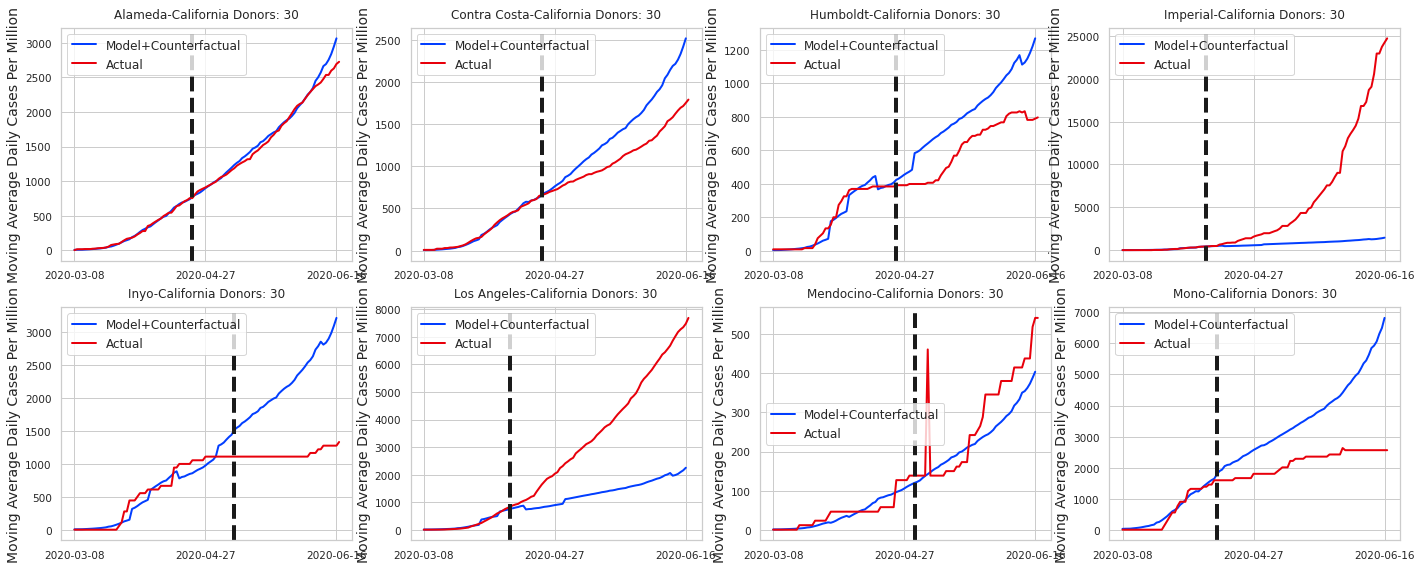

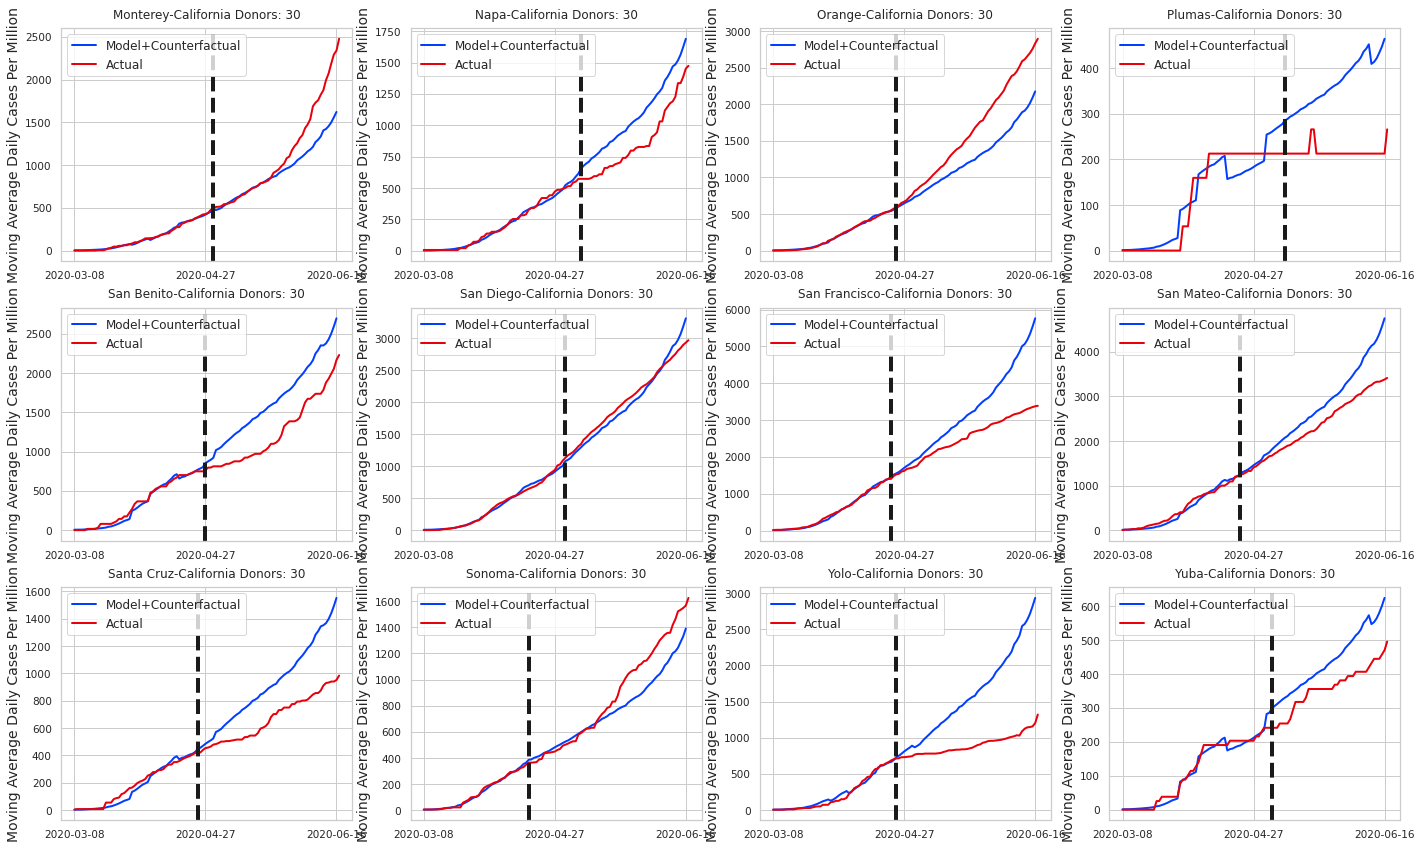

In [170]:
plt.rcParams.update({'font.size': 10})
tick_spacing=50

#sizes = df.applynortheastries.last_valid_index)
#sizes = sizes.fillna(0).astype(int)
targets = counties_mandated.copy()
donors = counties_not_mandated.copy()
singVals=2

num_rows_to_plot = int(len(targets)/4)+1
plt.rcParams['figure.figsize'] = (24, num_rows_to_plot*5.0)
#plt.rcParams['figure.figsize'] = (8, 6.0)

#California statewide mask mandate on June 18 so end the comparison at that point...
end_dt = datetime.strptime("2020-06-18", "%Y-%m-%d")
    
high_thresh = (end_dt - start_dt).days
#print(high_thresh)

i=1
print("Counterfactual analysis of CA Mask mandated counties based on a donor pool of Mask not mandated counties")
print("No donor pool filtering")
print("Intervention date specific to each county's order date (April 2-May 9)")
for county in targets:    
    #lookup treatment date
    filter = np.asarray(county)
    treatment_day = counties_mandated_dts[np.in1d(counties_mandated_dts[:,0], filter)][0][1]
    treatment_dt = datetime.strptime(treatment_day, "%Y-%m-%d")
    
    low_thresh = (treatment_dt - start_dt).days
    
    trainDF=df.iloc[:low_thresh,:]
    testDF=df.iloc[low_thresh+1:high_thresh,:]

    otherCounties =  donors.copy()
    if county in otherCounties:
        otherCounties.remove(county)
    all_rows = list.copy(otherCounties)
    all_rows.append(county)
    rscModel = RobustSyntheticControl(county, singVals, len(trainDF), probObservation=1.0, modelType='svd', svdMethod='numpy', otherSeriesKeysArray=otherCounties)
    rscModel.fit(trainDF)
    denoisedDF = rscModel.model.denoisedDF()
    predictions = []
    
    predictions = np.dot(testDF[otherCounties].values, rscModel.model.weights)
    predictions_noisy = np.dot(testDF[otherCounties].values, rscModel.model.weights)
    model_fit = np.dot(trainDF[otherCounties][:], rscModel.model.weights)
    fit_error = mse(model_fit, df[county][:low_thresh])
    prediction_error = mse(predictions, df[county][low_thresh+1:high_thresh])
    #print(county, fit_error, prediction_error)
    if(fit_error > 20):
        #print(county, fit_error)
        continue
    if((trainDF[county]>10).any()):
        #print(county)
        w=2
    else:
        continue
    ax = plt.subplot(num_rows_to_plot,4,i)
    #fig, ax = plt.subplots(1,1)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
    ax.set_title(county+" Donors: "+str(len(otherCounties)),fontsize=12, pad=10)
    plt.plot(np.concatenate((model_fit, predictions)), label='Model+Counterfactual'), plt.plot(df[county][0:high_thresh], label='Actual'), plt.legend(), 
    plt.ylabel('Moving Average Daily Cases Per Million'),
    plt.axvline(x=df.index[low_thresh], color='k', linestyle='--', linewidth=4), plt.legend()
    #plt.savefig("../figures/"+county+".png")
    i=i+1
    if(i==9):
        plt.show()
plt.show()

Counterfactual analysis of CA Mask mandated counties based on a donor pool of Mask recommended counties
Filtering based on initial per capita cases within 50%
Intervention date specific to each county's order date (April 2-May 9)


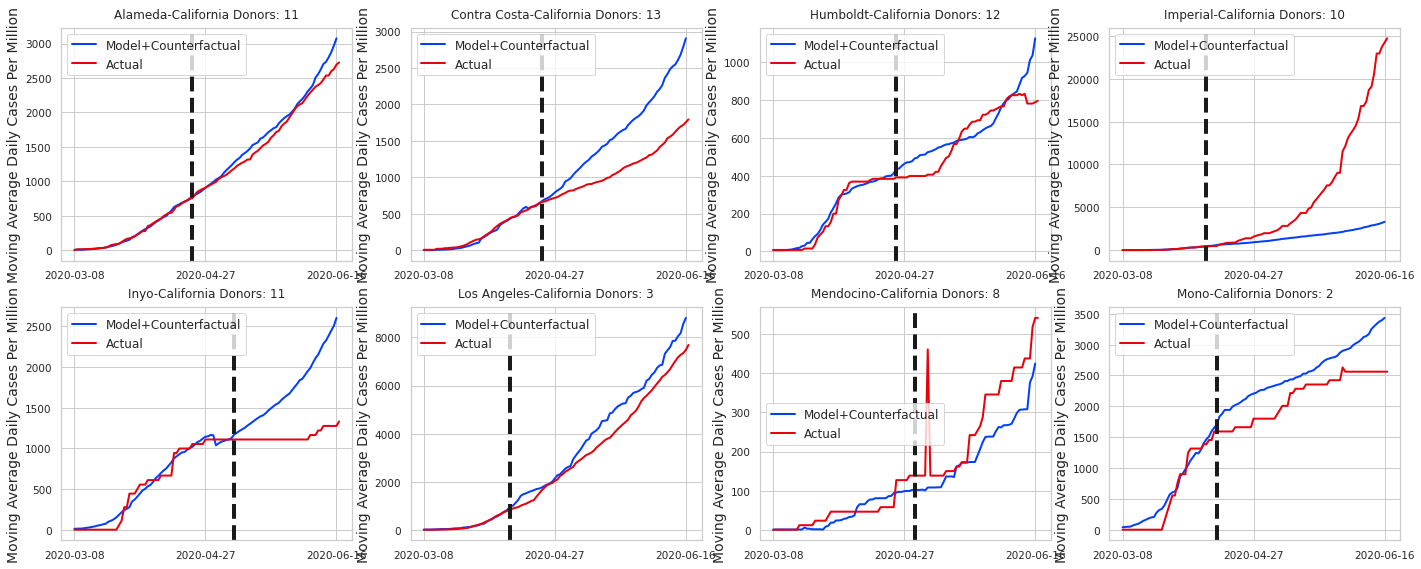

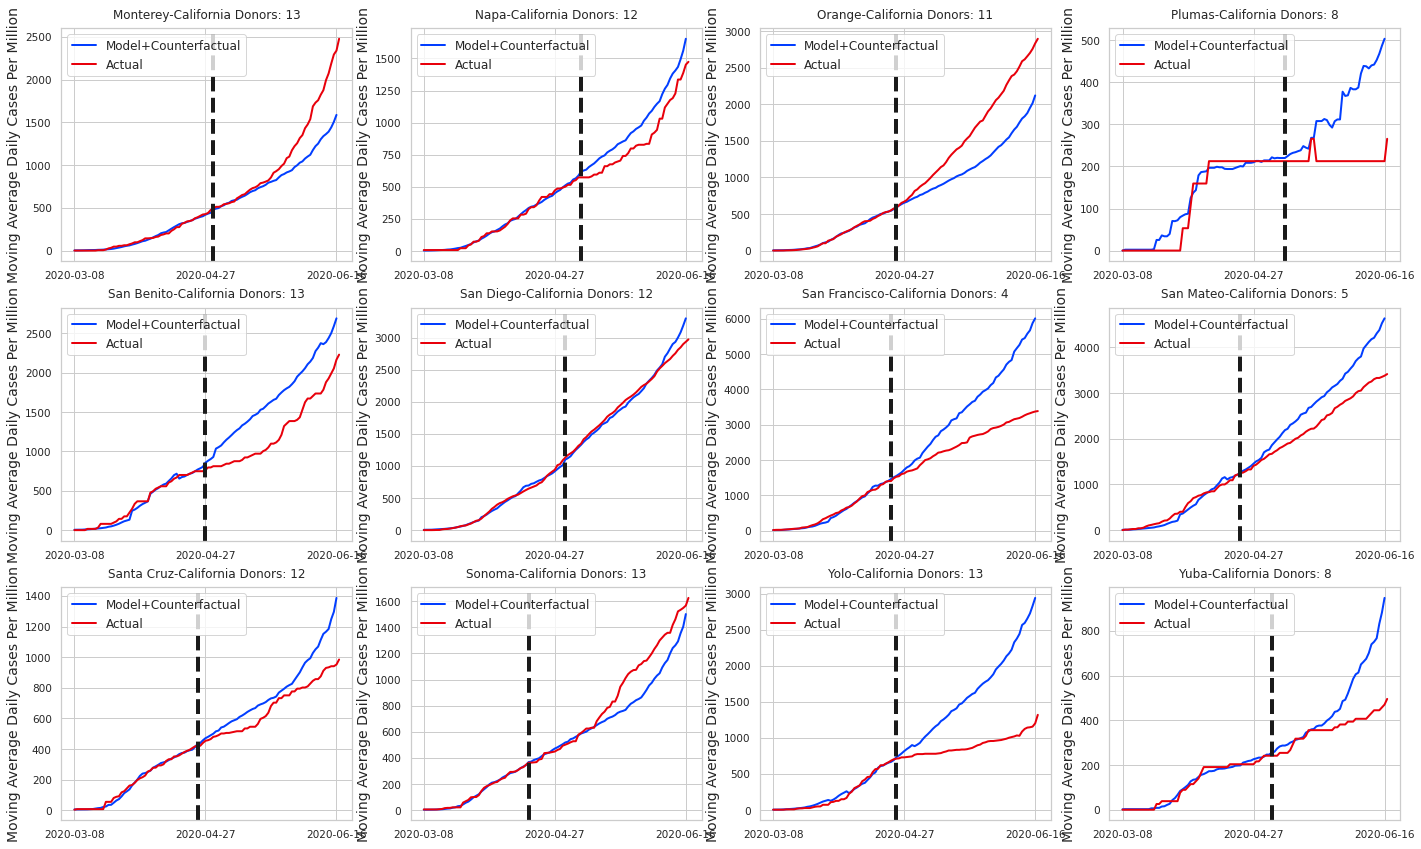

In [171]:
plt.rcParams.update({'font.size': 10})
tick_spacing=50

#sizes = df.applynortheastries.last_valid_index)
#sizes = sizes.fillna(0).astype(int)
targets = counties_mandated.copy()
donors = counties_not_mandated.copy()
singVals=2

num_rows_to_plot = int(len(targets)/4)+1
plt.rcParams['figure.figsize'] = (24, num_rows_to_plot*5.0)
#plt.rcParams['figure.figsize'] = (8, 6.0)

#California statewide mask mandate on June 18 so end the comparison at that point...
end_dt = datetime.strptime("2020-06-18", "%Y-%m-%d")
    
high_thresh = (end_dt - start_dt).days
#print(high_thresh)

i=1
print("Counterfactual analysis of CA Mask mandated counties based on a donor pool of Mask not mandated counties")
print("Filtering based on initial per capita cases within 50%")
print("Intervention date specific to each county's order date (April 2-May 9)")
for county in targets:    
    #lookup treatment date
    filter = np.asarray(county)
    treatment_day = counties_mandated_dts[np.in1d(counties_mandated_dts[:,0], filter)][0][1]
    treatment_dt = datetime.strptime(treatment_day, "%Y-%m-%d")
    
    low_thresh = (treatment_dt - start_dt).days
    
    trainDF=df.iloc[:low_thresh,:]
    testDF=df.iloc[low_thresh+1:high_thresh,:]

    #otherCounties =  donors.copy()
    otherCounties = df.columns[(df.iloc[low_thresh] < df[county].iloc[low_thresh]+.5*df[county].iloc[low_thresh])&(df.iloc[low_thresh] > df[county].iloc[low_thresh]-0.5*df[county].iloc[low_thresh])]
    otherCounties = list(otherCounties[otherCounties.isin(donors)])
    #print(state, "\n", len(otherCounties))
    if county in otherCounties:
        otherCounties.remove(county)
    all_rows = list.copy(otherCounties)
    all_rows.append(county)
    rscModel = RobustSyntheticControl(county, singVals, len(trainDF), probObservation=1.0, modelType='svd', svdMethod='numpy', otherSeriesKeysArray=otherCounties)
    rscModel.fit(trainDF)
    denoisedDF = rscModel.model.denoisedDF()
    predictions = []
    
    predictions = np.dot(testDF[otherCounties].values, rscModel.model.weights)
    predictions_noisy = np.dot(testDF[otherCounties].values, rscModel.model.weights)
    model_fit = np.dot(trainDF[otherCounties][:], rscModel.model.weights)
    fit_error = mse(model_fit, df[county][:low_thresh])
    prediction_error = mse(predictions, df[county][low_thresh+1:high_thresh])
    #print(county, fit_error, prediction_error)
    if(fit_error > 20):
        #print(county, fit_error)
        continue
    if((trainDF[county]>10).any()):
        #print(county)
        w=2
    else:
        continue
    ax = plt.subplot(num_rows_to_plot,4,i)
    #fig, ax = plt.subplots(1,1)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
    ax.set_title(county+" Donors: "+str(len(otherCounties)),fontsize=12, pad=10)
    plt.plot(np.concatenate((model_fit, predictions)), label='Model+Counterfactual'), plt.plot(df[county][0:high_thresh], label='Actual'), plt.legend(), 
    plt.ylabel('Moving Average Daily Cases Per Million'),
    plt.axvline(x=df.index[low_thresh], color='k', linestyle='--', linewidth=4), plt.legend()
    #plt.savefig("../figures/"+county+".png")
    i=i+1
    if(i==9):
        plt.show()
plt.show()

In [172]:
#print(google_ca_mobility.loc['Alameda-California'].to_list())
#apple_ca_driving_mobility['region']
apple_ca_mobility=apple_ca_driving_mobility
apple_ca_driving_mobility['region']=apple_ca_driving_mobility['region'].apply(lambda n : n.replace(' County', '-California'))
apple_ca_mobility=apple_ca_mobility.set_index('region')
apple_ca_mobility=apple_ca_mobility.drop(['geo_type', 'transportation_type', 'alternative_name', 'sub-region', 'country'], axis=1)
caa=apple_ca_mobility.index.values
#apple_ca_mobility=apple_ca_driving_mobility.pivot(index='county', columns='date', values='retail_and_recreation_percent_change_from_baseline')

In [173]:
apple_ca_mobility.loc[caa[0]]

2020-01-13    100.00
2020-01-14    102.85
2020-01-15    106.26
2020-01-16    107.14
2020-01-17    124.52
               ...  
2020-07-12     86.42
2020-07-13     95.61
2020-07-14    100.39
2020-07-15    102.24
2020-07-16    102.32
Name: Alameda-California, Length: 186, dtype: float64

Plot Apple driving mobility patterns for California counties


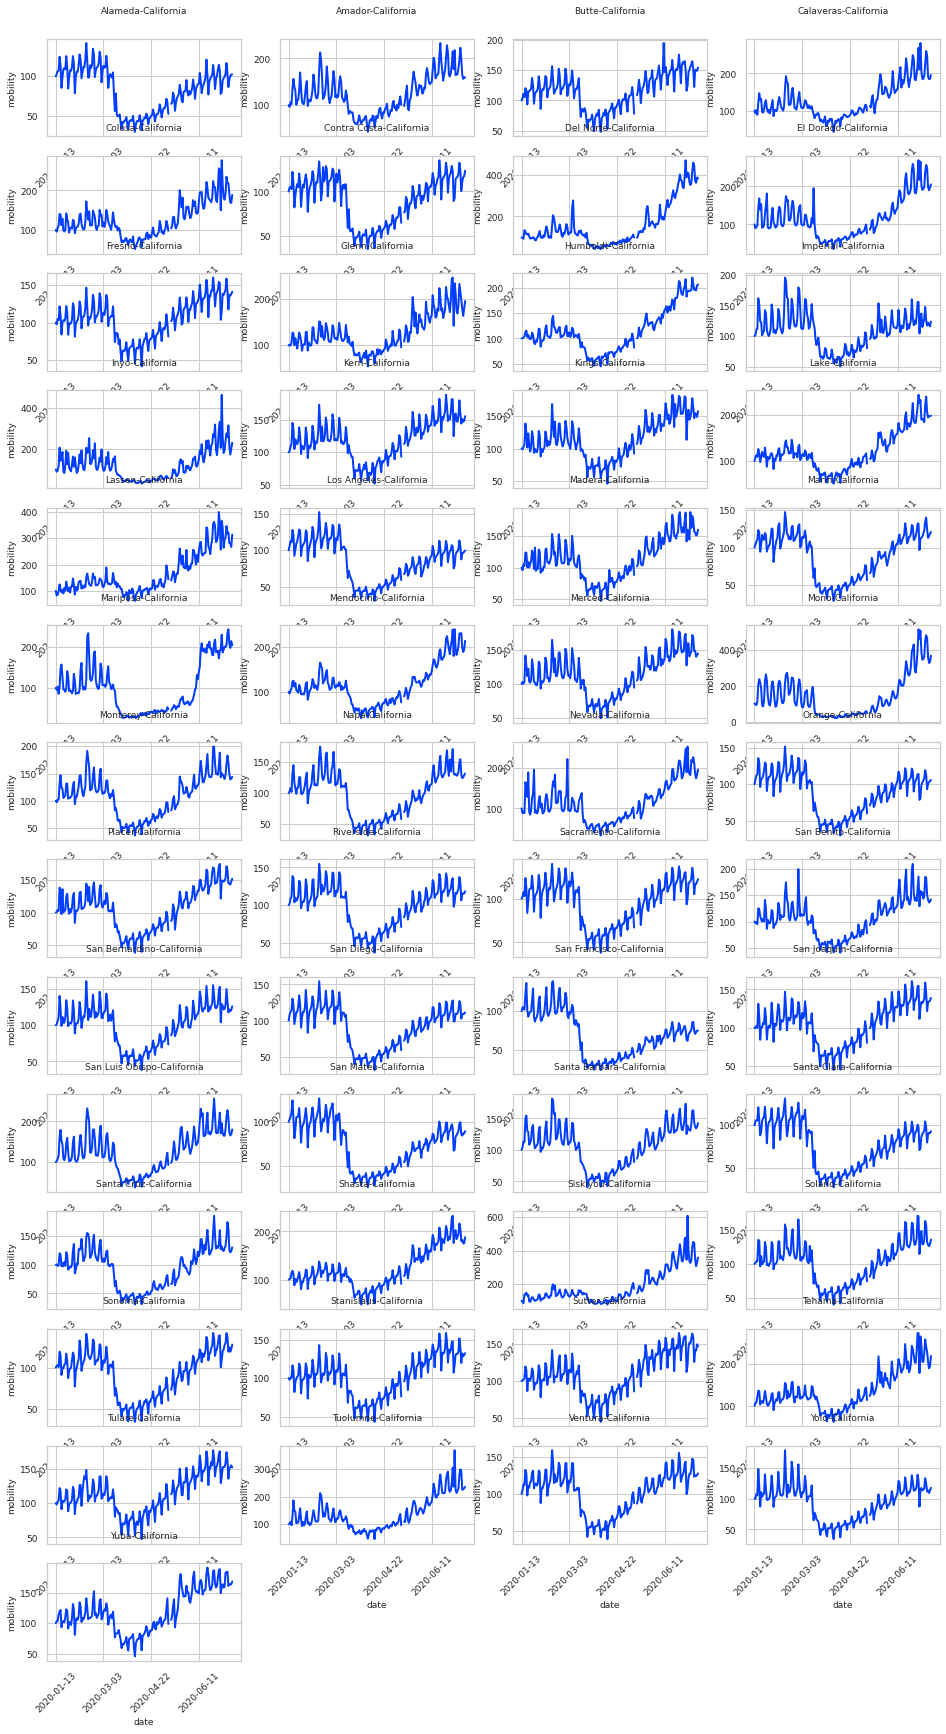

In [174]:
print("Plot Apple driving mobility patterns for California counties")
plt.rcParams['figure.figsize'] = (16,32)

FONTSIZE = 9

#cc = list(set(apple_ca_driving_mobility)-set(['Alpine-California','Sierra-California']))
#fig, ax = plt.subplots(4)
for i in range(len(caa)):
    ax = plt.subplot(15,4, i+1)
    #plt.setp( ax.get_xticklabels(), visible=False)

    #plt.xticks(rotation=45)

    apple_ca_mobility.loc[caa[i]].plot(ax=ax )
    #ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
    ax.set_xticklabels(ax.get_xticklabels(),rotation=45)

    #ax.tick_params(axis='x', rotation=45)
    plt.xlabel('date',fontsize = FONTSIZE), plt.ylabel('mobility',fontsize = FONTSIZE), 
    plt.xticks(fontsize = FONTSIZE), plt.yticks(fontsize = FONTSIZE), plt.title(caa[i], fontsize = FONTSIZE)


    
#plt.savefig('../Figures/COVID/google_ca_mobility.pdf', bbox_inches='tight')

plt.show()

Plot Google retail+recreation mobility patterns for California counties


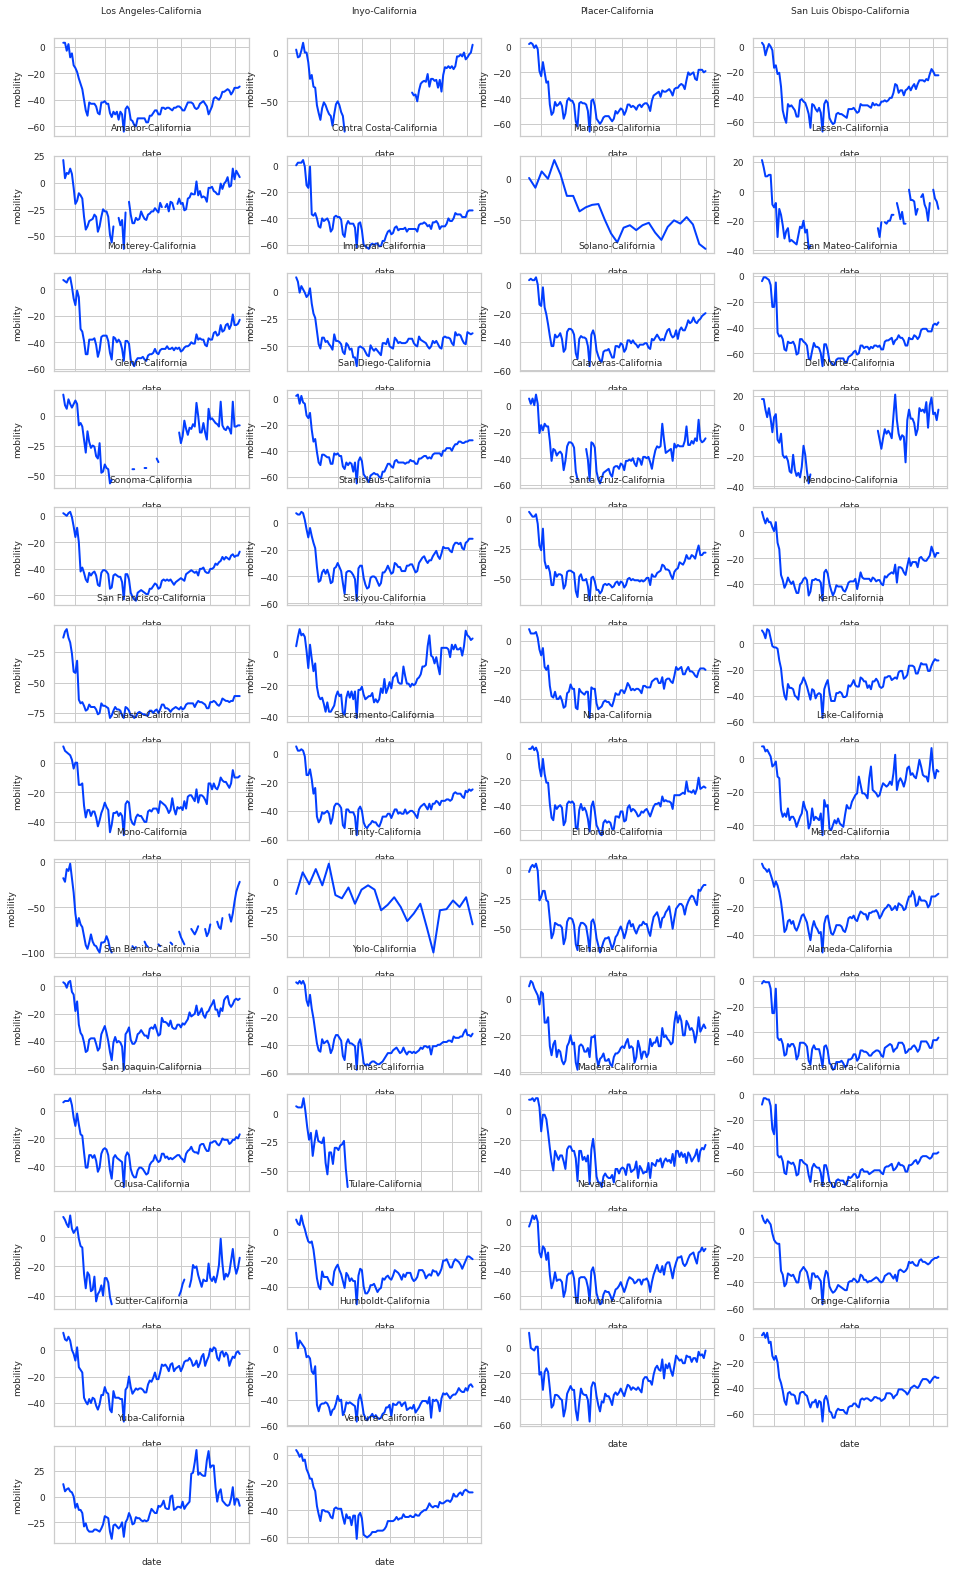

In [175]:
print("Plot Google retail+recreation mobility patterns for California counties")
plt.rcParams['figure.figsize'] = (16,32)

FONTSIZE = 9

cc = list(set(ca_counties)-set(['Alpine-California','Sierra-California']))
#fig, ax = plt.subplots(4)
for i in range(len(cc)):
    ax = plt.subplot(15,4, i+1)
    #plt.setp( ax.get_xticklabels(), visible=False)

    #plt.xticks(rotation=45)

    google_ca_mobility.loc[cc[i]].plot(ax=ax )
    #ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
    ax.set_xticklabels(ax.get_xticklabels(),rotation=45)

    #ax.tick_params(axis='x', rotation=45)
    plt.xlabel('date',fontsize = FONTSIZE), plt.ylabel('mobility',fontsize = FONTSIZE), 
    plt.xticks(fontsize = FONTSIZE), plt.yticks(fontsize = FONTSIZE), plt.title(cc[i], fontsize = FONTSIZE)


    
#plt.savefig('../Figures/COVID/google_ca_mobility.pdf', bbox_inches='tight')

plt.show()

In [18]:
def compute_corr(x,y):
    #print (x,y,stats.pearsonr(x, y)[0])
    return stats.pearsonr(x, y)[0]

In [177]:
counties_mandated

['Alameda-California',
 'Contra Costa-California',
 'Del Norte-California',
 'Humboldt-California',
 'Imperial-California',
 'Inyo-California',
 'Los Angeles-California',
 'Mendocino-California',
 'Mono-California',
 'Monterey-California',
 'Napa-California',
 'Orange-California',
 'Plumas-California',
 'San Benito-California',
 'San Diego-California',
 'San Francisco-California',
 'San Mateo-California',
 'Santa Cruz-California',
 'Sierra-California',
 'Sonoma-California',
 'Yolo-California',
 'Yuba-California']

(53, 100)
(28, 100)
Counterfactual analysis of CA Mask mandated counties based on a donor pool of Mask recommended counties
Filtering based on initial per capita cases within 50% and Apple mobility trend correlations
Intervention date specific to each county's order date (April 2-May 9)
Only  0  counties for  0.95  for Inyo-California
Only  1  counties for  0.9  for Inyo-California
Lowered threshold to  0.85  for  Inyo-California
Only  0  counties for  0.95  for Imperial-California
Only  1  counties for  0.9  for Imperial-California
Lowered threshold to  0.85  for  Imperial-California
Only  1  counties for  0.95  for Del Norte-California
Lowered threshold to  0.9  for  Del Norte-California
Only  1  counties for  0.95  for San Francisco-California
Only  1  counties for  0.9  for San Francisco-California
Lowered threshold to  0.85  for  San Francisco-California
Only  0  counties for  0.95  for Mono-California
Only  0  counties for  0.9  for Mono-California
Only  0  counties for  0.85  fo

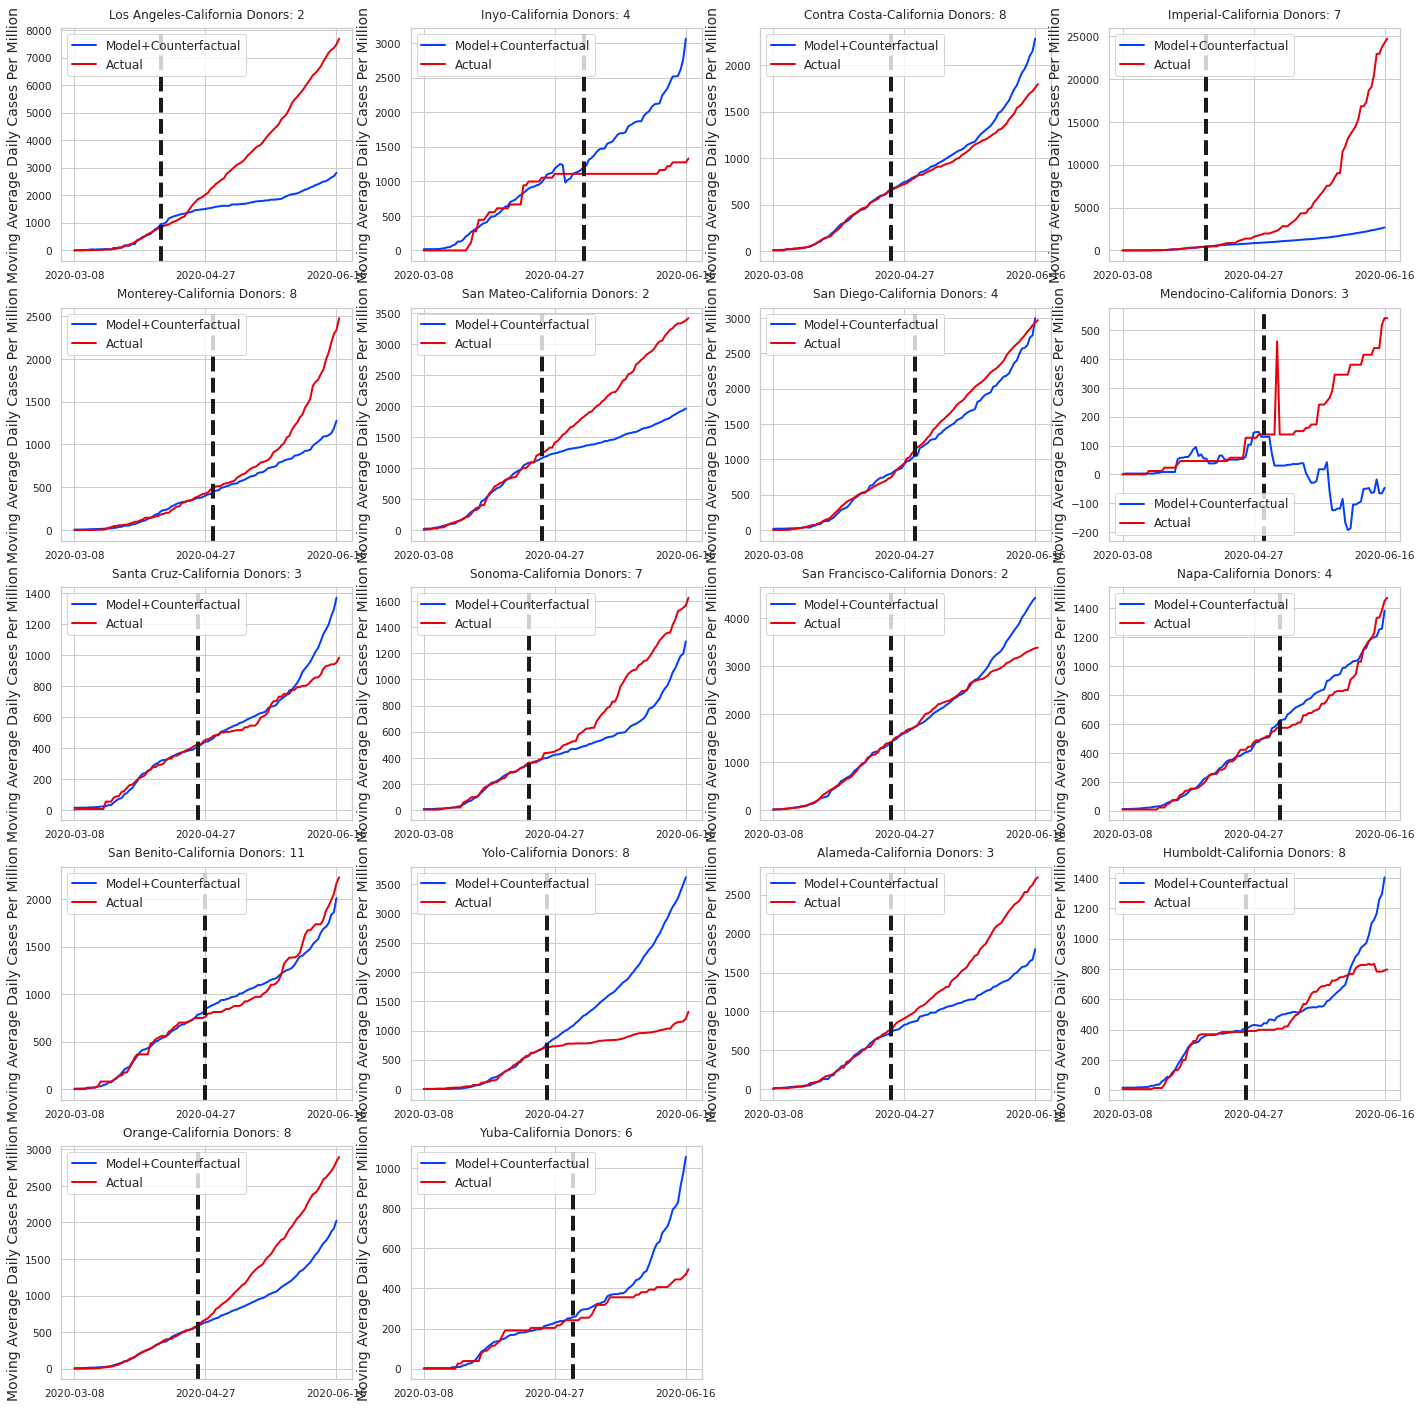

In [185]:
import pandas as pd
import numpy as np
import scipy.stats as stats
from datetime import timedelta  

correlation_thresholds = [0.95, 0.9, 0.85]
#correlation_thresholds = [0.85, 0.75, 0.65, 0.5]
        
plt.rcParams.update({'font.size': 10})
tick_spacing=50

targets = list(set(counties_mandated).intersection(caa))
donors = list(set(counties_not_mandated).intersection(caa))
singVals=2

num_rows_to_plot = int(len(targets)/4)+1
plt.rcParams['figure.figsize'] = (24, num_rows_to_plot*5.0)

#California statewide mask mandate on June 18 so end the comparison at that point...
end_dt = datetime.strptime("2020-06-18", "%Y-%m-%d")
    
high_thresh = (end_dt - start_dt).days
#print(high_thresh)

drop_dates = set(apple_ca_mobility.loc[caa[0]].index.values)
dt = start_dt
while dt < end_dt:
    drop_dates.remove(dt.strftime("%Y-%m-%d"))
    dt = dt + timedelta(days=1)
#data glitch - no data for these days...
drop_dates.add('2020-05-11')
drop_dates.add('2020-05-12')
in_range_mobility=apple_ca_mobility.drop(drop_dates, axis=1)

#print(apple_ca_mobility.loc[caa[1]].to_string())
hasmobility = in_range_mobility.dropna()
print(hasmobility.shape)

donor_mobility = hasmobility[hasmobility.index.isin(donors)]
print(donor_mobility.shape)


i=1
print("Counterfactual analysis of CA Mask mandated counties based on a donor pool of Mask not mandated counties")
print("Filtering based on initial per capita cases within 50% and Apple mobility trend correlations")
print("Intervention date specific to each county's order date (April 2-May 9)")
for county in targets:    
    #lookup treatment date
    filter = np.asarray(county)
    treatment_day = counties_mandated_dts[np.in1d(counties_mandated_dts[:,0], filter)][0][1]
    treatment_dt = datetime.strptime(treatment_day, "%Y-%m-%d")
    
    low_thresh = (treatment_dt - start_dt).days
    
    trainDF=df.iloc[:low_thresh,:]
    testDF=df.iloc[low_thresh+1:high_thresh,:]

    #otherCounties =  donors.copy()
    otherCounties = df.columns[(df.iloc[low_thresh] < df[county].iloc[low_thresh]+.5*df[county].iloc[low_thresh])&(df.iloc[low_thresh] > df[county].iloc[low_thresh]-0.5*df[county].iloc[low_thresh])]
    otherCounties = list(otherCounties[otherCounties.isin(donors)])
    if county in otherCounties:
        otherCounties.remove(county)

    matches = []
    for correlation_threshold in correlation_thresholds:
        high_corr = donor_mobility[donor_mobility.apply(lambda r : compute_corr(hasmobility.loc[county], r), axis=1)>=correlation_threshold]
        matches = list(set(otherCounties).intersection(high_corr.index.values))
        if (len(matches)>=2):
            #print(len(matches), " counties for ", correlation_threshold, " for "+county)
            if (correlation_threshold < correlation_thresholds[0]):
                print("Lowered threshold to ", correlation_threshold, " for ", county)
            break
        print("Only ", len(matches), " counties for ", correlation_threshold, " for "+county)
    if (not matches):
        print("Insufficient donor pool for ", county)
        continue
    otherCounties = matches
        
    #TODO push down into loop to filter
    #        r = stats.pearsonr(hasmobility.loc[a].to_list(), hasmobility.loc[b].to_list())

    all_rows = list.copy(otherCounties)
    all_rows.append(county)
    rscModel = RobustSyntheticControl(county, singVals, len(trainDF), probObservation=1.0, modelType='svd', svdMethod='numpy', otherSeriesKeysArray=otherCounties)
    rscModel.fit(trainDF)
    denoisedDF = rscModel.model.denoisedDF()
    predictions = []
    
    predictions = np.dot(testDF[otherCounties].values, rscModel.model.weights)
    predictions_noisy = np.dot(testDF[otherCounties].values, rscModel.model.weights)
    model_fit = np.dot(trainDF[otherCounties][:], rscModel.model.weights)
    fit_error = mse(model_fit, df[county][:low_thresh])
    prediction_error = mse(predictions, df[county][low_thresh+1:high_thresh])
    #print(county, fit_error, prediction_error)
    if(fit_error > 20):
        #print(county, fit_error)
        continue
    if((trainDF[county]>10).any()):
        #print(county)
        w=2
    else:
        continue
    ax = plt.subplot(num_rows_to_plot,4,i)
    #fig, ax = plt.subplots(1,1)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
    ax.set_title(county+" Donors: "+str(len(otherCounties)),fontsize=12, pad=10)
    plt.plot(np.concatenate((model_fit, predictions)), label='Model+Counterfactual'), plt.plot(df[county][0:high_thresh], label='Actual'), plt.legend(), 
    plt.ylabel('Moving Average Daily Cases Per Million'),
    plt.axvline(x=df.index[low_thresh], color='k', linestyle='--', linewidth=4), plt.legend()
    #plt.savefig("../figures/"+county+".png")
    i=i+1
    #if(i==9):
        #plt.show()
plt.show()


Counterfactual analysis of CA Mask mandated counties based on a donor pool of Mask recommended counties
Filtering based on initial per capita cases within 50% and Google mobility trend correlations
Intervention date specific to each county's order date (April 2-May 9)
Lowered threshold to  0.9  for  Contra Costa-California
Lowered threshold to  0.9  for  Imperial-California
Lowered threshold to  0.9  for  San Benito-California
Lowered threshold to  0.9  for  Alameda-California
Insufficient donor pool for  Yuba-California
Lowered threshold to  0.9  for  San Francisco-California


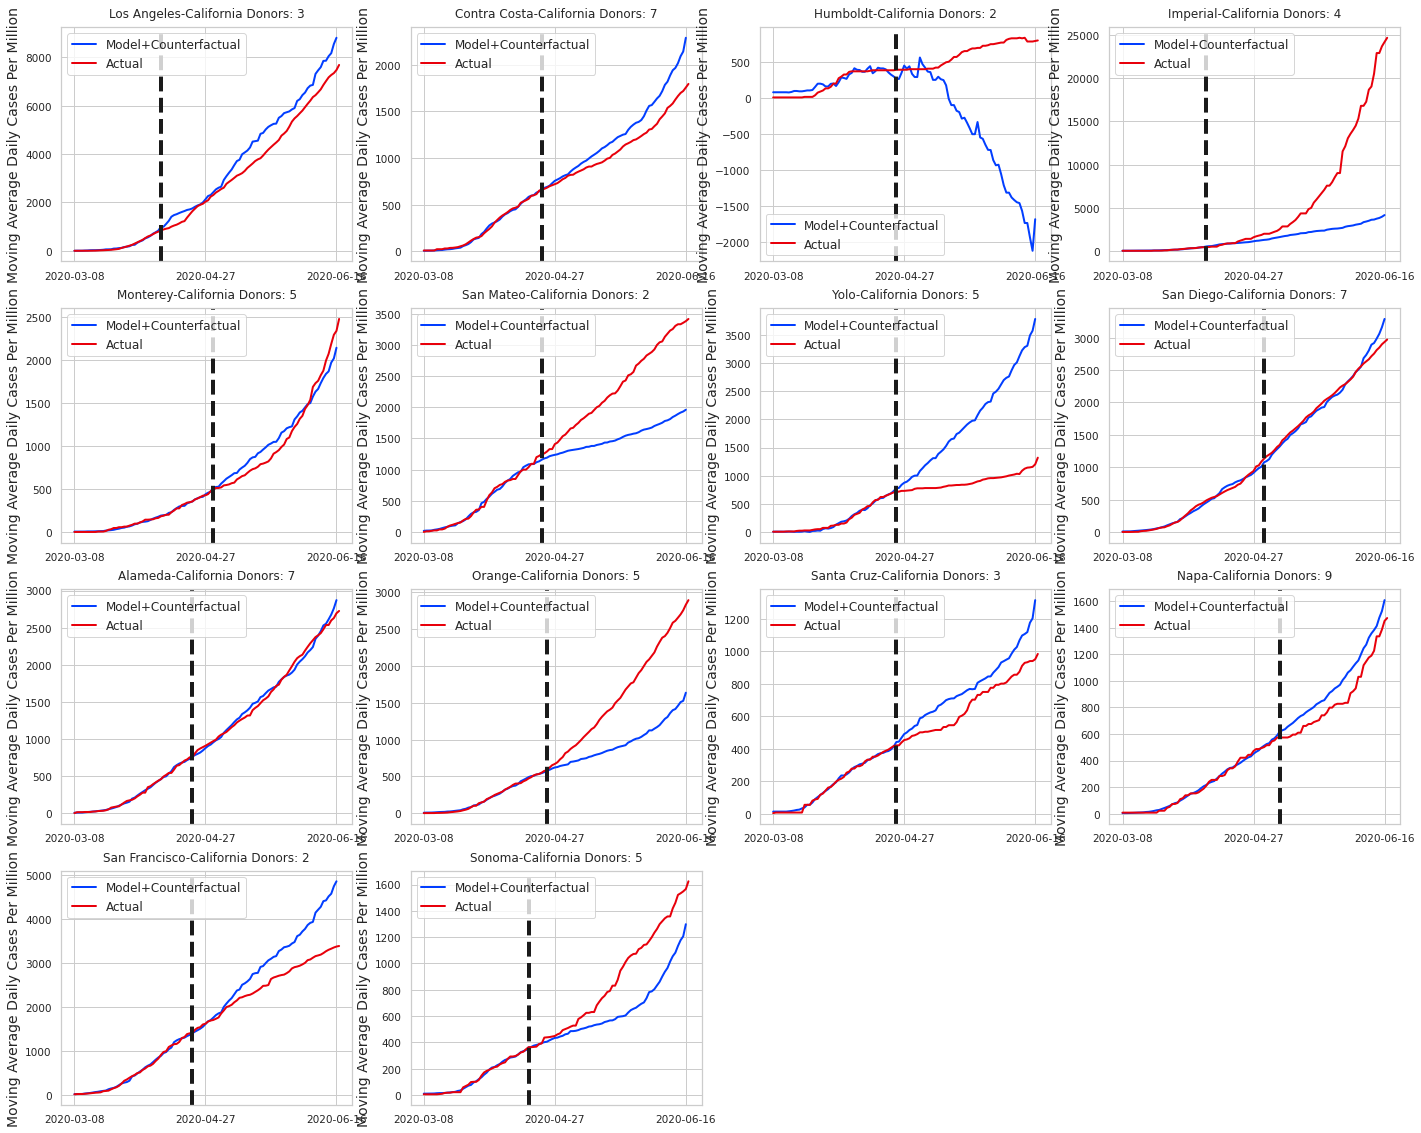

In [183]:
import pandas as pd
import numpy as np
import scipy.stats as stats

hasmobility = google_ca_mobility.dropna()

#remove counties with NaN mobility values
cc = set(ca_counties)-set(['Alpine-California','Sierra-California','Lassen-California','Del Norte-California','Trinity-California','Mono-California',
                               'Calaveras-California', 'Plumas-California', 'Amador-California', 'Inyo-California','Colusa-California','Glenn-California',
                               'Mariposa-California'])

correlation_thresholds = [0.95, 0.9, 0.85]
#correlation_thresholds = [0.88, 0.85]
        
plt.rcParams.update({'font.size': 10})
tick_spacing=50

targets = list(set(counties_mandated).intersection(cc))
donors = list(set(counties_not_mandated).intersection(cc))
singVals=2

donor_mobility = hasmobility[hasmobility.index.isin(donors)]
#print(donor_mobility)

num_rows_to_plot = int(len(targets)/4)+1
plt.rcParams['figure.figsize'] = (24, num_rows_to_plot*5.0)

#California statewide mask mandate on June 18 so end the comparison at that point...
end_dt = datetime.strptime("2020-06-18", "%Y-%m-%d")
    
high_thresh = (end_dt - start_dt).days
#print(high_thresh)

i=1
print("Counterfactual analysis of CA Mask mandated counties based on a donor pool of Mask not mandated counties")
print("Filtering based on initial per capita cases within 50% and Google mobility trend correlations")
print("Intervention date specific to each county's order date (April 2-May 9)")
for county in targets:    
    #lookup treatment date
    filter = np.asarray(county)
    treatment_day = counties_mandated_dts[np.in1d(counties_mandated_dts[:,0], filter)][0][1]
    treatment_dt = datetime.strptime(treatment_day, "%Y-%m-%d")
    
    low_thresh = (treatment_dt - start_dt).days
    
    trainDF=df.iloc[:low_thresh,:]
    testDF=df.iloc[low_thresh+1:high_thresh,:]

    #otherCounties =  donors.copy()
    otherCounties = df.columns[(df.iloc[low_thresh] < df[county].iloc[low_thresh]+.5*df[county].iloc[low_thresh])&(df.iloc[low_thresh] > df[county].iloc[low_thresh]-0.5*df[county].iloc[low_thresh])]
    otherCounties = list(otherCounties[otherCounties.isin(donors)])
    if county in otherCounties:
        otherCounties.remove(county)

    matches = []
    for correlation_threshold in correlation_thresholds:
        high_corr = donor_mobility[donor_mobility.apply(lambda r : compute_corr(hasmobility.loc[county], r), axis=1)>=correlation_threshold]
        matches = list(set(otherCounties).intersection(high_corr.index.values))
        if (len(matches)>=2):
            #print(len(matches), " counties for ", correlation_treshold, " for "+county)
            if (correlation_threshold < correlation_thresholds[0]):
                print("Lowered threshold to ", correlation_threshold, " for ", county)
            break
        #print("Only ", len(matches), " counties for ", correlation_treshold, " for "+county)
    if (not matches):
        print("Insufficient donor pool for ", county)
        continue
    otherCounties = matches
        
    #TODO push down into loop to filter
    #        r = stats.pearsonr(hasmobility.loc[a].to_list(), hasmobility.loc[b].to_list())

    all_rows = list.copy(otherCounties)
    all_rows.append(county)
    rscModel = RobustSyntheticControl(county, singVals, len(trainDF), probObservation=1.0, modelType='svd', svdMethod='numpy', otherSeriesKeysArray=otherCounties)
    rscModel.fit(trainDF)
    denoisedDF = rscModel.model.denoisedDF()
    predictions = []
    
    predictions = np.dot(testDF[otherCounties].values, rscModel.model.weights)
    predictions_noisy = np.dot(testDF[otherCounties].values, rscModel.model.weights)
    model_fit = np.dot(trainDF[otherCounties][:], rscModel.model.weights)
    fit_error = mse(model_fit, df[county][:low_thresh])
    prediction_error = mse(predictions, df[county][low_thresh+1:high_thresh])
    #print(county, fit_error, prediction_error)
    if(fit_error > 20):
        #print(county, fit_error)
        continue
    if((trainDF[county]>10).any()):
        #print(county)
        w=2
    else:
        continue
    ax = plt.subplot(num_rows_to_plot,4,i)
    #fig, ax = plt.subplots(1,1)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
    ax.set_title(county+" Donors: "+str(len(otherCounties)),fontsize=12, pad=10)
    plt.plot(np.concatenate((model_fit, predictions)), label='Model+Counterfactual'), plt.plot(df[county][0:high_thresh], label='Actual'), plt.legend(), 
    plt.ylabel('Moving Average Daily Cases Per Million'),
    plt.axvline(x=df.index[low_thresh], color='k', linestyle='--', linewidth=4), plt.legend()
    #plt.savefig("../figures/"+county+".png")
    i=i+1
#    if(i==9):
#        plt.show()
plt.show()


Plot R_t for California mask mandated counties


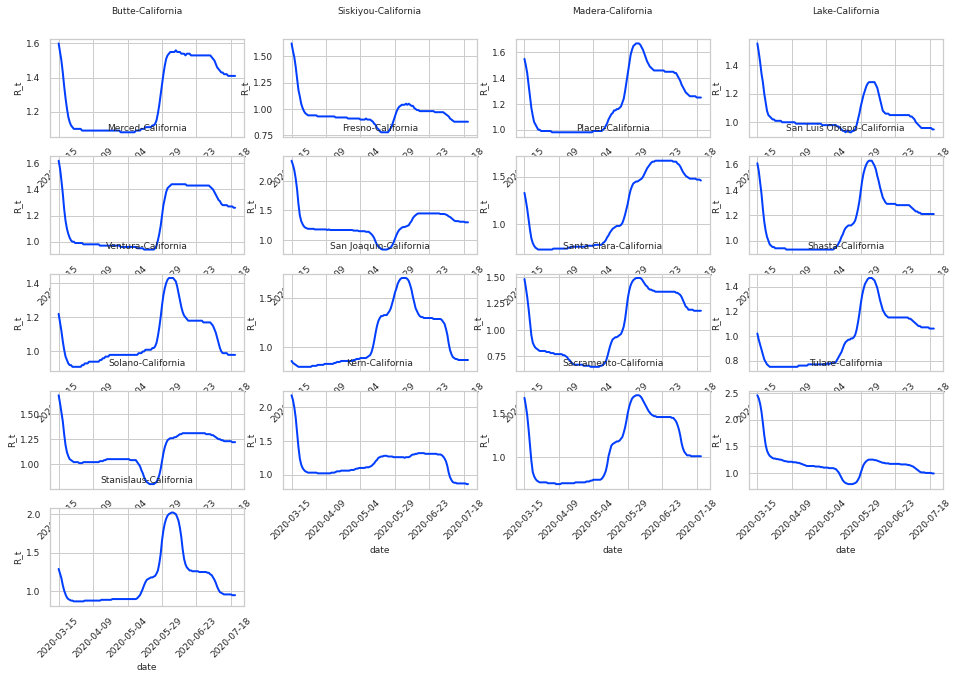

In [66]:
print("Plot R_t for California mask mandated counties")
plt.rcParams['figure.figsize'] = (16,32)

FONTSIZE = 9

#remove counties with NaN mobility values
cc = set(ca_counties)-set(['Alpine-California','Sierra-California','Lassen-California','Del Norte-California','Trinity-California','Mono-California',
                               'Calaveras-California', 'Plumas-California', 'Amador-California', 'Inyo-California','Colusa-California','Glenn-California',
                           'Humboldt-California', 'San Benito-California', 'Mendocino-California',
                           'Sutter-California', 'Tehama-California', 'Tuolumne-California', 
                           'El Dorado-California', 'Nevada-California',#some bug - skip for now
                               'Mariposa-California'])

donors = list(set(counties_not_mandated).intersection(cc))

#fig, ax = plt.subplots(4)
for i in range(len(donors)):
    ax = plt.subplot(15,4, i+1)
    #plt.setp( ax.get_xticklabels(), visible=False)

    #plt.xticks(rotation=45)

    lemma_rt.loc[donors[i]].plot(ax=ax )
    #ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
    ax.set_xticklabels(ax.get_xticklabels(),rotation=45)

    #ax.tick_params(axis='x', rotation=45)
    plt.xlabel('date',fontsize = FONTSIZE), plt.ylabel('R_t',fontsize = FONTSIZE), 
    plt.xticks(fontsize = FONTSIZE), plt.yticks(fontsize = FONTSIZE), plt.title(donors[i], fontsize = FONTSIZE)


    
#plt.savefig('../Figures/COVID/google_ca_mobility.pdf', bbox_inches='tight')

plt.show()

Plot CFR for California mask mandated counties


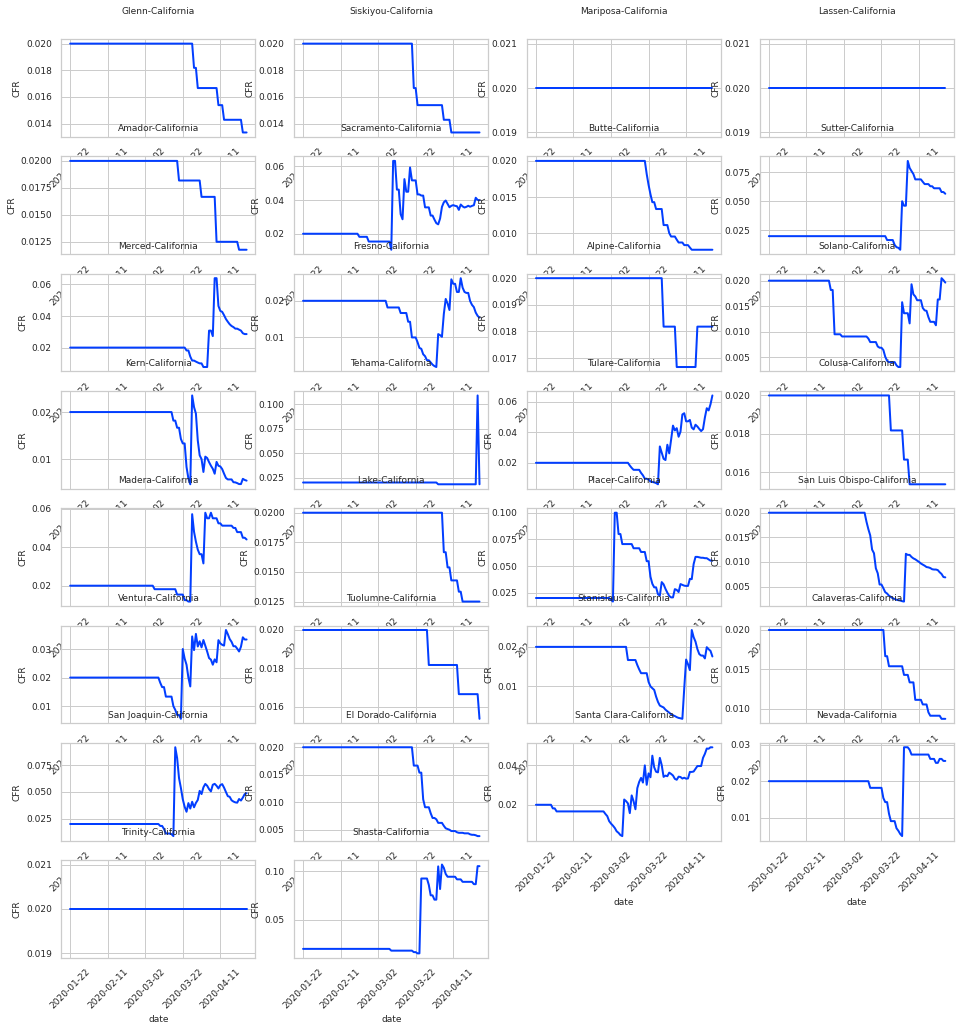

In [75]:
print("Plot CFR for California mask mandated counties")
plt.rcParams['figure.figsize'] = (16,32)

deaths = uscounties_deaths.iloc[:high_thresh, :]
cases = uscounties_cases.iloc[:high_thresh,:]

#CFR - use a prior weight of 2% for this period to smooth out noise from low volumes
cfr =  (deaths + .2) / (cases + 10.)

#print(deaths.loc[:,'Los Angeles-California'])

FONTSIZE = 9

donors = list(set(counties_not_mandated).intersection(set(ca_counties)))

#fig, ax = plt.subplots(4)
for i in range(len(donors)):
    ax = plt.subplot(15,4, i+1)
    #plt.setp( ax.get_xticklabels(), visible=False)

    #plt.xticks(rotation=45)

    cfr.loc[:,donors[i]].plot(ax=ax )
    #ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
    ax.set_xticklabels(ax.get_xticklabels(),rotation=45)

    #ax.tick_params(axis='x', rotation=45)
    plt.xlabel('date',fontsize = FONTSIZE), plt.ylabel('CFR',fontsize = FONTSIZE), 
    plt.xticks(fontsize = FONTSIZE), plt.yticks(fontsize = FONTSIZE), plt.title(donors[i], fontsize = FONTSIZE)

plt.show()

Plot CFR for California not mask mandated counties


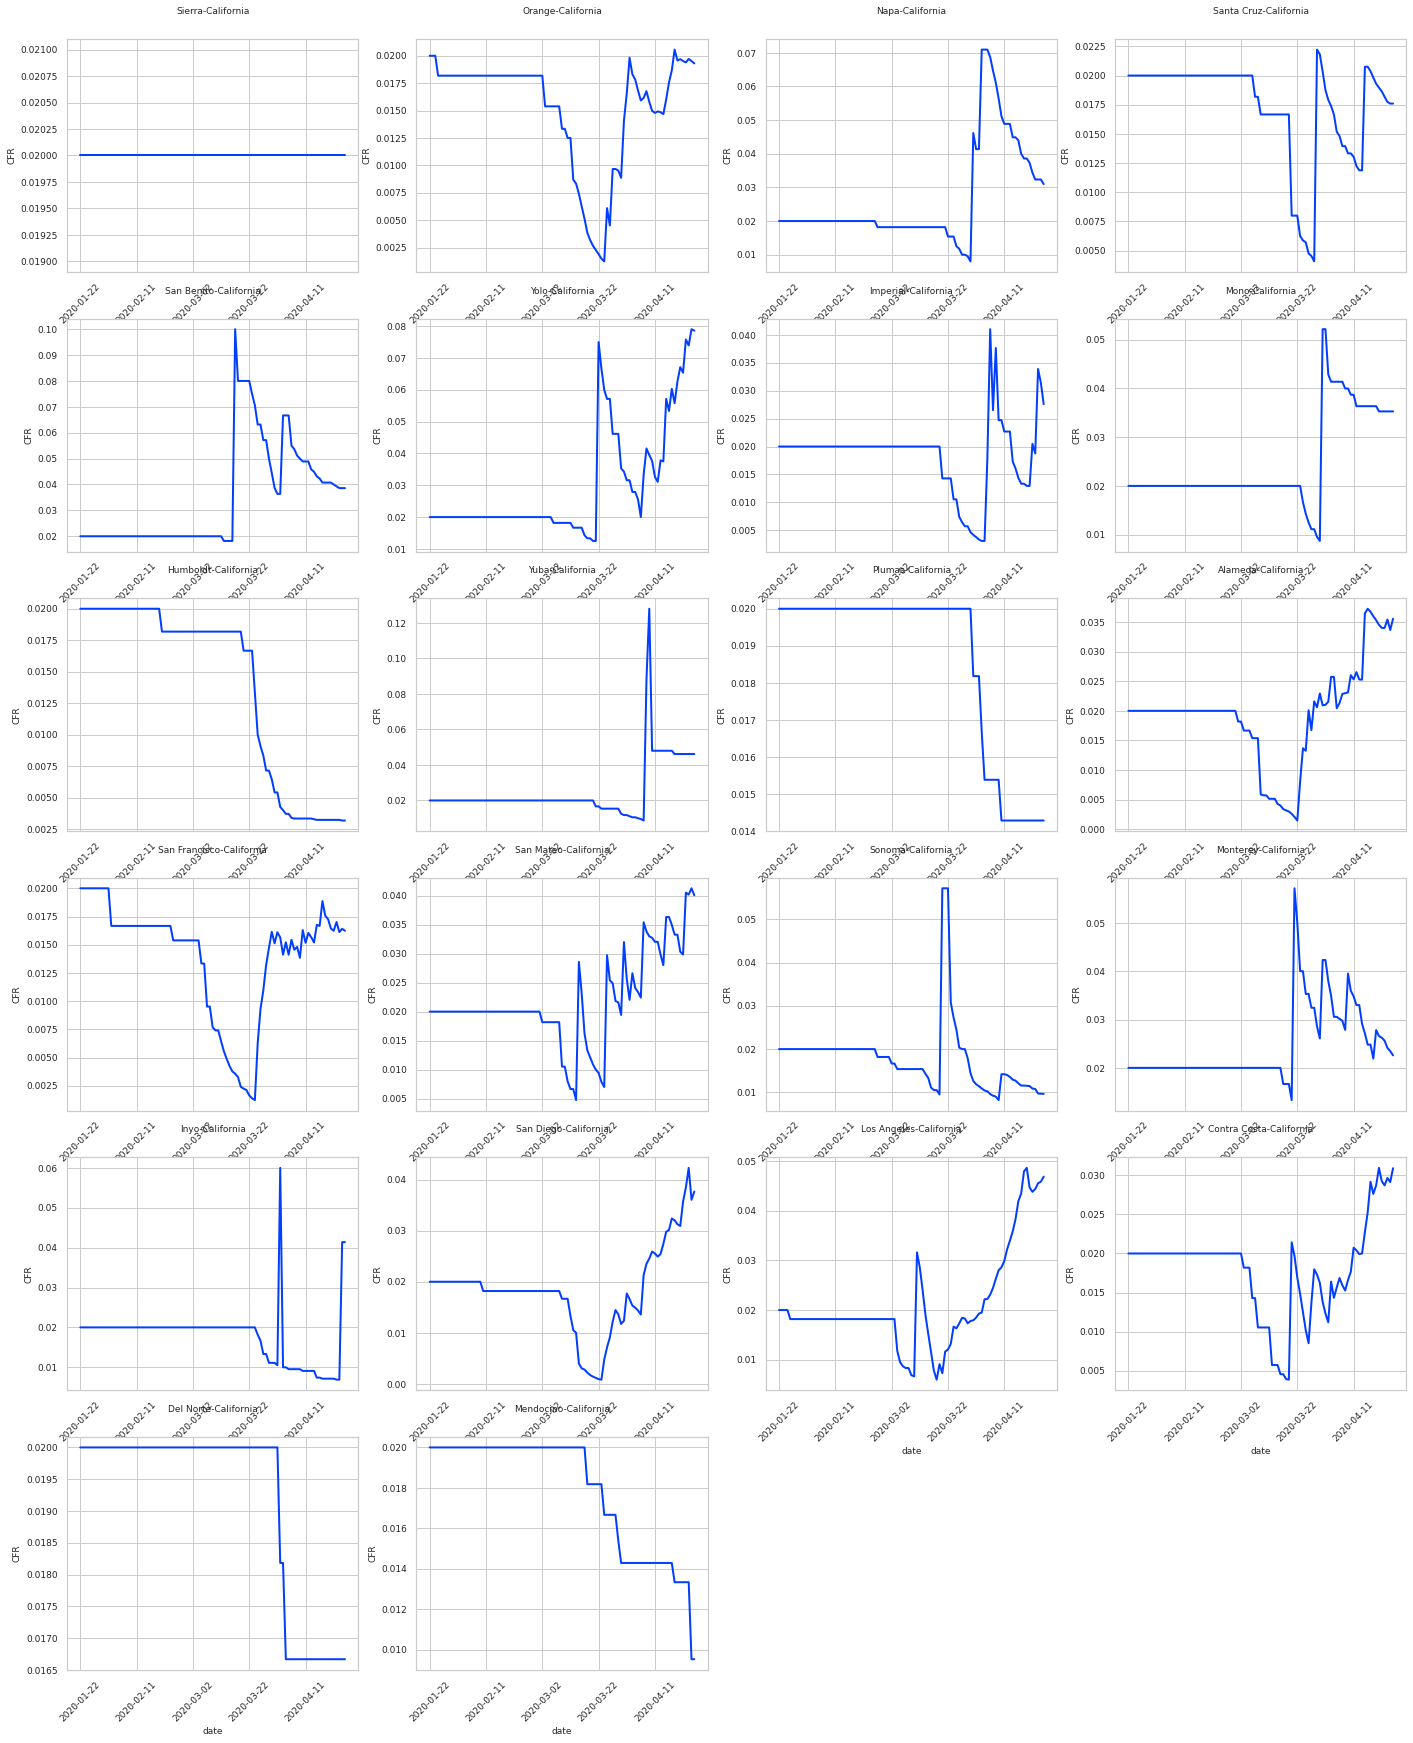

In [87]:
print("Plot CFR for California not mask mandated counties")

deaths = uscounties_deaths.iloc[:high_thresh, :]
cases = uscounties_cases.iloc[:high_thresh,:]

#CFR - use a prior weight of 2% for this period to smooth out noise from low volumes
cfr =  (deaths + .2) / (cases + 10.)

#print(deaths.loc[:,'Los Angeles-California'])

FONTSIZE = 9

donors = list(set(counties_mandated).intersection(set(ca_counties)))

num_rows_to_plot = int(len(donors)/4)+1
plt.rcParams['figure.figsize'] = (24, num_rows_to_plot*5.0)


#fig, ax = plt.subplots(4)
for i in range(len(donors)):
    ax = plt.subplot(num_rows_to_plot,4,i+1)
    #plt.setp( ax.get_xticklabels(), visible=False)

    #plt.xticks(rotation=45)

    cfr.loc[:,donors[i]].plot(ax=ax )
    #ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
    ax.set_xticklabels(ax.get_xticklabels(),rotation=45)

    #ax.tick_params(axis='x', rotation=45)
    plt.xlabel('date',fontsize = FONTSIZE), plt.ylabel('CFR',fontsize = FONTSIZE), 
    plt.xticks(fontsize = FONTSIZE), plt.yticks(fontsize = FONTSIZE), plt.title(donors[i], fontsize = FONTSIZE)

plt.show()

Counterfactual R_t analysis of CA Mask mandated counties based on a donor pool of Mask not mandated counties
Filtering based on initial per capita cases within 50% and Google mobility trend correlations
Intervention date specific to each county's order date (April 2-May 9)


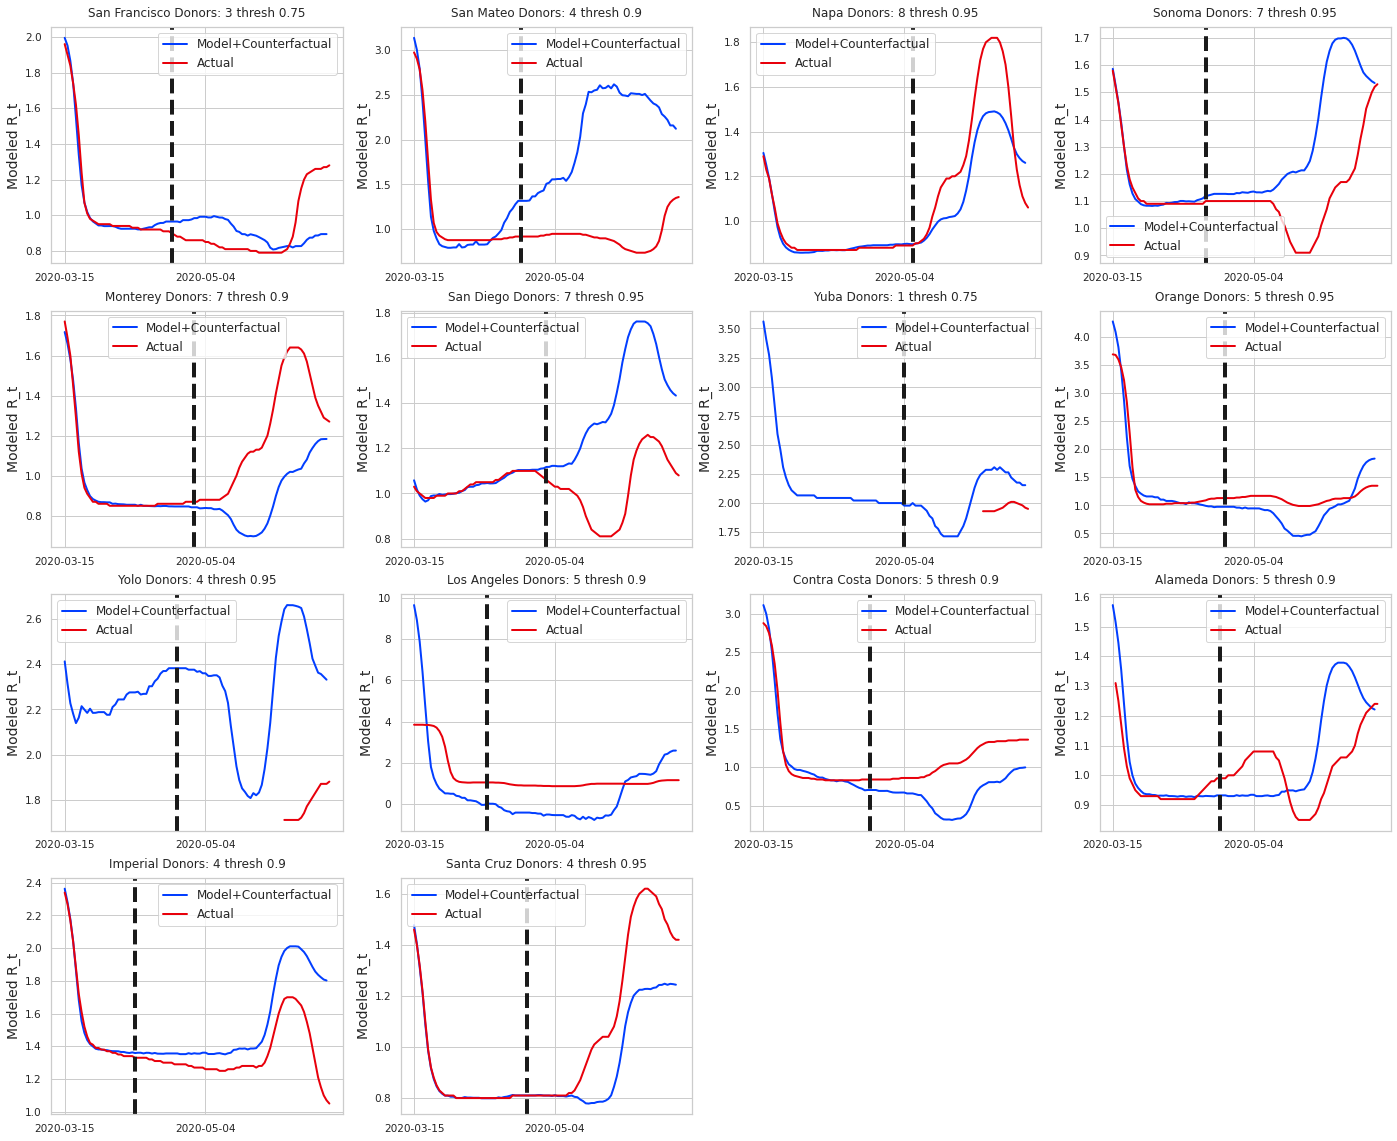

In [34]:
import pandas as pd
import numpy as np
import scipy.stats as stats

hasmobility = google_ca_mobility.dropna()

#remove counties with NaN mobility values
cc = set(ca_counties)-set(['Alpine-California','Sierra-California','Lassen-California','Del Norte-California','Trinity-California','Mono-California',
                               'Calaveras-California', 'Plumas-California', 'Amador-California', 'Inyo-California','Colusa-California','Glenn-California',
                           'Humboldt-California', 'San Benito-California', 'Mendocino-California', #some bug - skip for now
                               'Mariposa-California'])

#correlation_thresholds = [0.95, 0.9, 0.85]
correlation_thresholds = [0.95, 0.9, 0.85, 0.8, 0.75]
        
plt.rcParams.update({'font.size': 10})
tick_spacing=50

targets = list(set(counties_mandated).intersection(cc))
donors = list(set(counties_not_mandated).intersection(cc))
singVals=2

donor_mobility = hasmobility[hasmobility.index.isin(donors)]
#print(donor_mobility)

num_rows_to_plot = int(len(targets)/4)+1
plt.rcParams['figure.figsize'] = (24, num_rows_to_plot*5.0)

#California statewide mask mandate on June 18 so end the comparison at that point...
end_dt = datetime.strptime("2020-06-18", "%Y-%m-%d")
    
high_thresh = (end_dt - start_rt_dt).days
#print(high_thresh)

i=1
print("Counterfactual R_t analysis of CA Mask mandated counties based on a donor pool of Mask not mandated counties")
print("Filtering based on initial per capita cases within 50% and Google mobility trend correlations")
print("Intervention date specific to each county's order date (April 2-May 9)")
for county in targets:    
    #lookup treatment date
    filter = np.asarray(county)
    treatment_day = counties_mandated_dts[np.in1d(counties_mandated_dts[:,0], filter)][0][1]
    treatment_dt = datetime.strptime(treatment_day, "%Y-%m-%d")
    
    low_thresh = (treatment_dt - start_rt_dt).days
    
#    trainDF=df.iloc[:low_thresh,:]
#    testDF=df.iloc[low_thresh+1:high_thresh,:]
    trainLemma=lemma_rt.T.iloc[:low_thresh,:]
    testLemma=lemma_rt.T.iloc[low_thresh+1:high_thresh,:]
    
    #otherCounties =  donors.copy()
    otherCounties = df.columns[(df.iloc[low_thresh] < df[county].iloc[low_thresh]+.5*df[county].iloc[low_thresh])&(df.iloc[low_thresh] > df[county].iloc[low_thresh]-0.5*df[county].iloc[low_thresh])]
    otherCounties = list(otherCounties[otherCounties.isin(donors)])
    if county in otherCounties:
        otherCounties.remove(county)

    matches = []
    for correlation_threshold in correlation_thresholds:
        high_corr = donor_mobility[donor_mobility.apply(lambda r : compute_corr(hasmobility.loc[county], r), axis=1)>=correlation_threshold]
        matches = list(set(otherCounties).intersection(high_corr.index.values))
        if (len(matches)>=4):
            #print(len(matches), " counties for ", correlation_threshold, " for "+county)
#            if (correlation_threshold < correlation_thresholds[0]):
#                print("Lowered threshold to ", correlation_threshold, " for ", county)
            break
        #print("Only ", len(matches), " counties for ", correlation_treshold, " for "+county)
    if (not matches):
        print("Insufficient donor pool for ", county)
        continue
    otherCounties = matches
        
    #TODO push down into loop to filter
    #        r = stats.pearsonr(hasmobility.loc[a].to_list(), hasmobility.loc[b].to_list())

    #remove counties not in R_t data set
    otherCounties = list(set(otherCounties).intersection(set(trainLemma.columns.values)))
    #print(county, otherCounties)

    
    all_rows = list.copy(otherCounties)
    all_rows.append(county)
    rscModel = RobustSyntheticControl(county, singVals, len(trainLemma), probObservation=1.0, modelType='svd', svdMethod='numpy', otherSeriesKeysArray=otherCounties)
    rscModel.fit(trainLemma)
    denoisedDF = rscModel.model.denoisedDF()
    predictions = []
    
    predictions = np.dot(testLemma[otherCounties].values, rscModel.model.weights)
    predictions_noisy = np.dot(testLemma[otherCounties].values, rscModel.model.weights)
    model_fit = np.dot(trainLemma[otherCounties][:], rscModel.model.weights)
    fit_error = mse(model_fit, lemma_rt.T[county][:low_thresh])
    prediction_error = mse(predictions, lemma_rt.T[county][low_thresh+1:high_thresh])
    if(fit_error > 20):
        print(county, "fit error: ", fit_error)
        continue
#    if((trainLemma[county]>10).any()):
#        print(county)
#        w=2
#    else:
#        print("Skipped")
#        continue
    ax = plt.subplot(num_rows_to_plot,4,i)
    #fig, ax = plt.subplots(1,1)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
    ax.set_title(county.replace("-California","")+" Donors: "+str(len(otherCounties))+" thresh "+
                 str(correlation_threshold),fontsize=12, pad=10)
    plt.plot(np.concatenate((model_fit, predictions)), label='Model+Counterfactual'), plt.plot(lemma_rt.T[county][0:high_thresh], label='Actual'), plt.legend(), 
    plt.ylabel('Modeled R_t'),
    plt.axvline(x=lemma_rt.T.index[low_thresh], color='k', linestyle='--', linewidth=4), plt.legend()
    #plt.savefig("../figures/"+county+".png")
    i=i+1
#    if(i==9):
#        plt.show()
plt.show()

Counterfactual analysis of CA Mask recommended counties based on a donor pool of Mask mandated counties
Intervention date:  2020-05-09


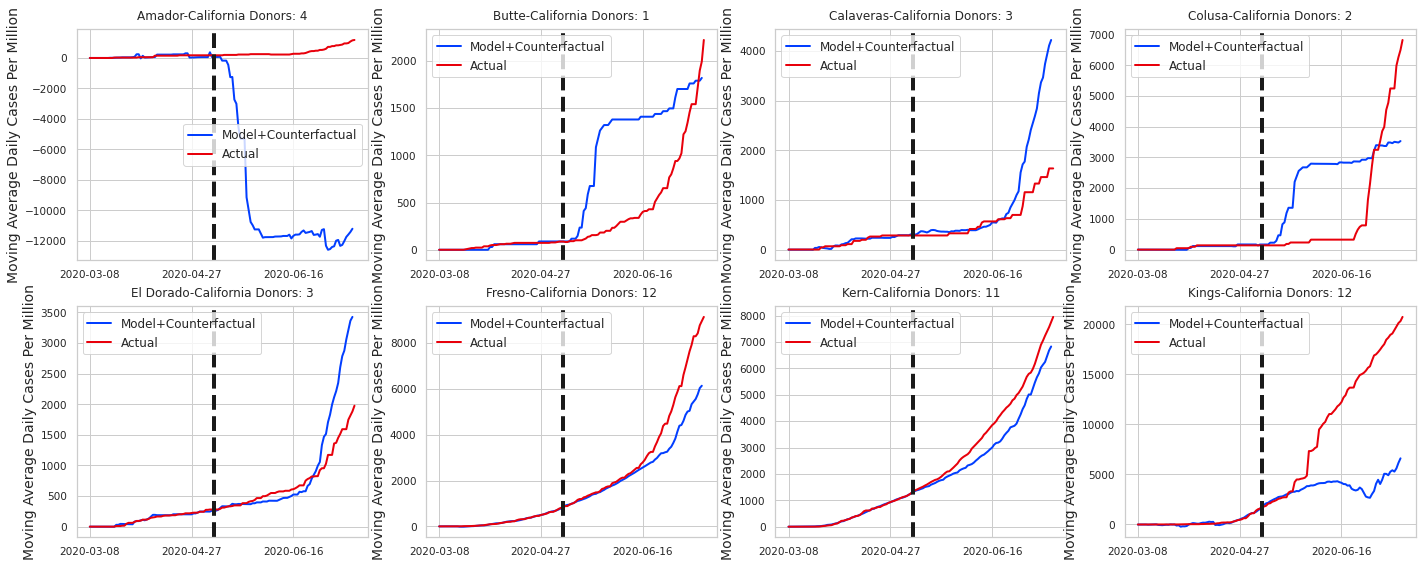

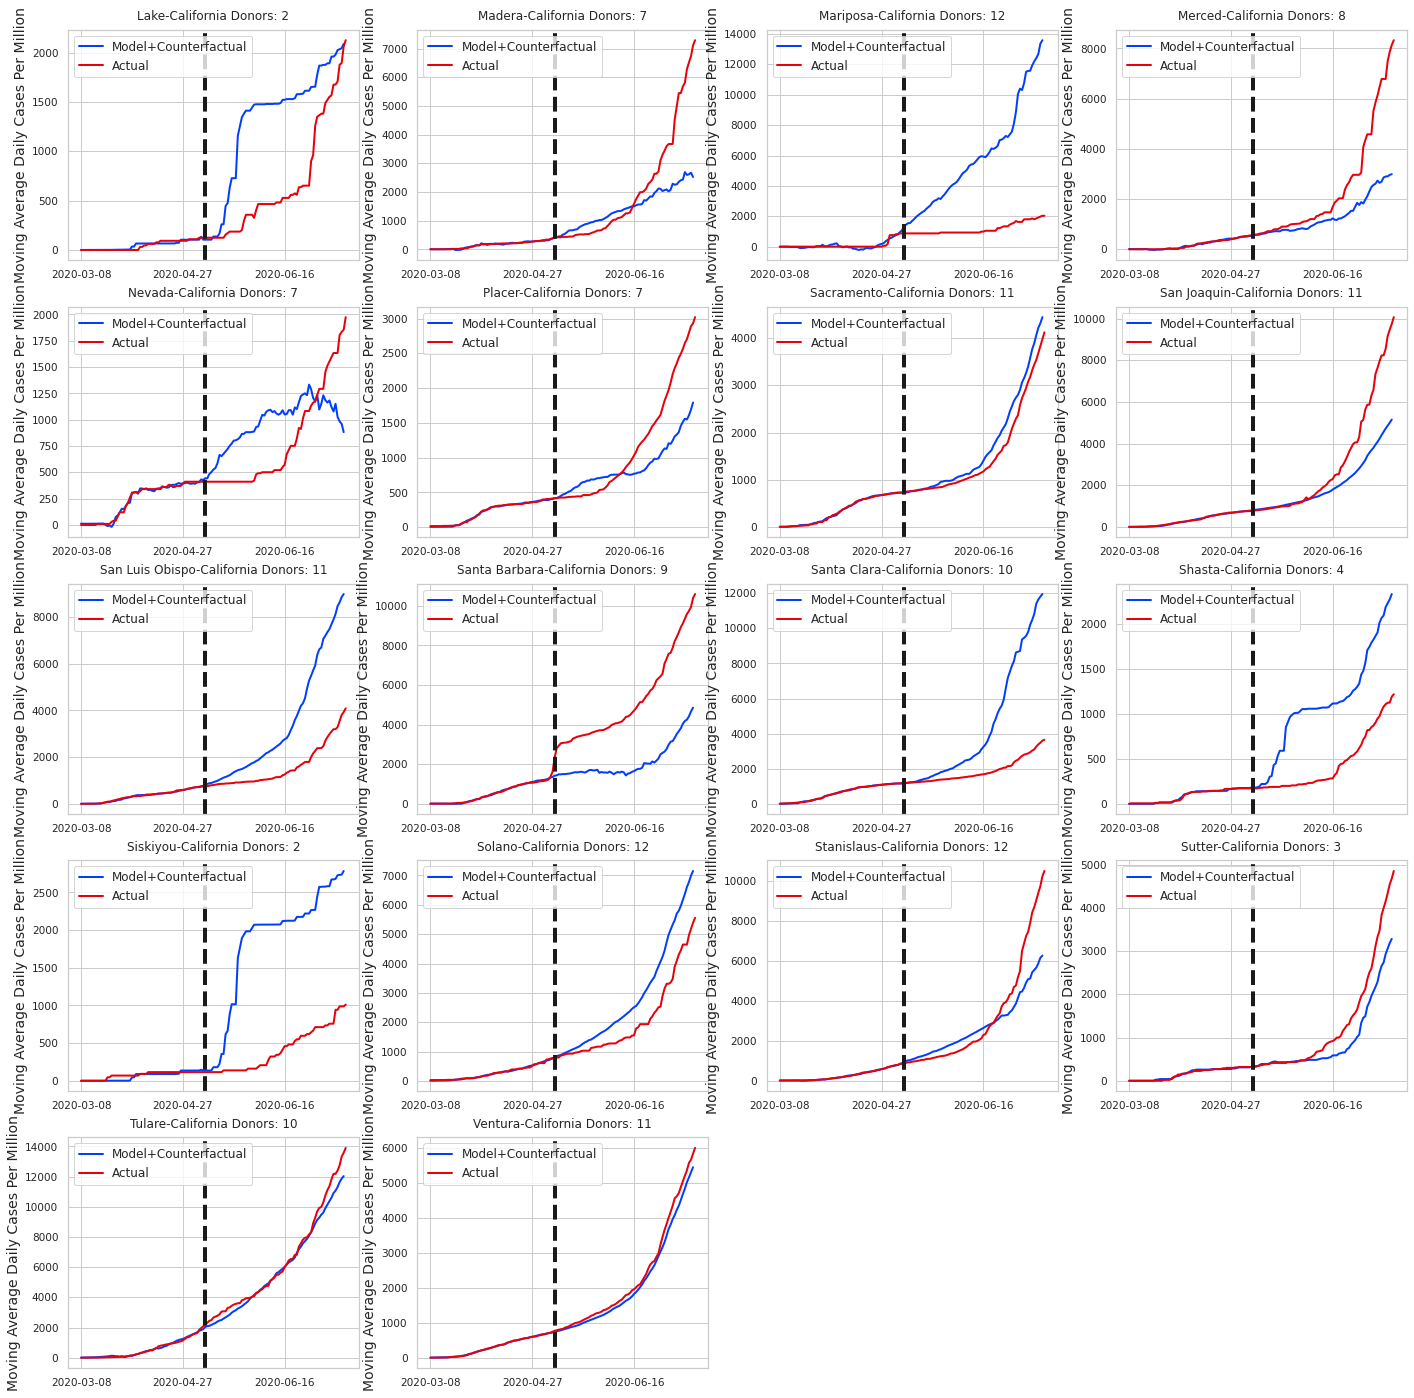

In [44]:

#df = df[df.columns[(df>100).any()]].copy()
plt.rcParams.update({'font.size': 10})
tick_spacing=50

#sizes = df.applynortheastries.last_valid_index)
#sizes = sizes.fillna(0).astype(int)
high_thresh = df.shape[0]
low_thresh = high_thresh-71
#targets = paired_list.copy() #counties_not_mandated #masks_mandated
targets = counties_not_mandated.copy()
donors = counties_mandated.copy()
singVals=4
trainDF=df.iloc[:low_thresh,:]
testDF=df.iloc[low_thresh+1:high_thresh,:]

num_rows_to_plot = int(len(targets)/4)+1
plt.rcParams['figure.figsize'] = (24, num_rows_to_plot*5.0)
#plt.rcParams['figure.figsize'] = (8, 6.0)

i=1
print("Counterfactual analysis of CA Mask not mandated counties based on a donor pool of Mask mandated counties")
print("Intervention date: ", testDF.index[0])
for county in targets:
    #otherCounties =  donors.copy()
    otherCounties = df.columns[(df.iloc[low_thresh] < df[county].iloc[low_thresh]+.5*df[county].iloc[low_thresh])&(df.iloc[low_thresh] > df[county].iloc[low_thresh]-0.5*df[county].iloc[low_thresh])]
    otherCounties = list(otherCounties[otherCounties.isin(donors)])
    #print(county, "\n", len(otherCounties))
    if county in otherCounties:
        otherCounties.remove(county)
    all_rows = list.copy(otherCounties)
    all_rows.append(county)
    rscModel = RobustSyntheticControl(county, singVals, len(trainDF), probObservation=1.0, modelType='svd', svdMethod='numpy', otherSeriesKeysArray=otherCounties)
    rscModel.fit(trainDF)
    denoisedDF = rscModel.model.denoisedDF()
    predictions = []
    
    predictions = np.dot(testDF[otherCounties].values, rscModel.model.weights)
    predictions_noisy = np.dot(testDF[otherCounties].values, rscModel.model.weights)
    model_fit = np.dot(trainDF[otherCounties][:], rscModel.model.weights)
    fit_error = mse(model_fit, df[county][:low_thresh])
    prediction_error = mse(predictions, df[county][low_thresh+1:])
    #print(county, fit_error, prediction_error)
    if(fit_error > 20):
        #print(county, fit_error)
        continue
    if((traindf[county]>10).any()):
        #print(county)
        w=2
    else:
        continue
    ax = plt.subplot(num_rows_to_plot,4,i)
    #fig, ax = plt.subplots(1,1)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
    ax.set_title(county+" Donors: "+str(len(otherCounties)),fontsize=12, pad=10)
    plt.plot(np.concatenate((model_fit, predictions)), label='Model+Counterfactual'), plt.plot(df[county], label='Actual'), plt.legend(), 
    plt.ylabel('Moving Average Daily Cases Per Million'),
    plt.axvline(x=df.index[low_thresh], color='k', linestyle='--', linewidth=4), plt.legend()
    #plt.savefig("../figures/"+county+".png")
    i=i+1
    if(i==9):
        plt.show()
plt.show()


### error in prediction vs number of cases per million analysis

Intervention date:  2020-06-04


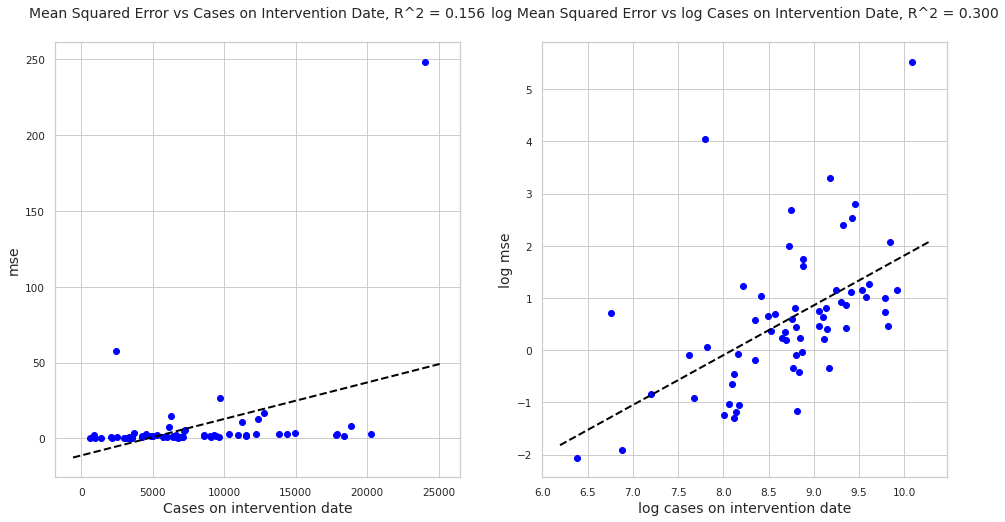

In [32]:
high_thresh = df.shape[0]
low_thresh = high_thresh-45
targets = counties_not_mandated #counties_not_mandated #masks_mandated
donors = counties_mandated.copy() 
singVals=3
trainDF=df.iloc[:low_thresh,:]
testDF=df.iloc[low_thresh+1:high_thresh,:]

print("Intervention date: ", testDF.index[0])

cases_list, error_list = [], []
cases_list_log, error_list_log = [], [] # I experimented with using matplotlib's builtin log scale, but I found this solution worked better

for county in targets:
    otherCounties = df.columns[(df.iloc[low_thresh] < df[county].iloc[low_thresh]+.5*df[county].iloc[low_thresh])&(df.iloc[low_thresh] > df[county].iloc[low_thresh]-0.5*df[county].iloc[low_thresh])]
    otherCounties = list(otherCounties[otherCounties.isin(donors)])
    if county in otherCounties:
        otherCounties.remove(county)
    rscModel = RobustSyntheticControl(county, singVals, len(trainDF), probObservation=1.0, modelType='svd', svdMethod='numpy', otherSeriesKeysArray=otherCounties)
    rscModel.fit(trainDF)
    
    model_fit = np.dot(trainDF[otherCounties][:], rscModel.model.weights)
    fit_error = mse(model_fit, df[county][:low_thresh])
    
    if not math.isnan(fit_error):
        cases = df[county][low_thresh]
        #cases = np.mean(df[county][low_thresh-7:low_thresh])
        
        cases_list.append(cases)
        error_list.append(fit_error)
        
        cases_list_log.append(np.log(cases))
        error_list_log.append(np.log(fit_error))
    
#TODO trend

    
fig_mse_cases, (ax_mse_cases, ax_mse_cases_log) = plt.subplots(1, 2, figsize=(16,8))
    
ax_mse_cases.scatter(cases_list, error_list, c='blue')
ax_mse_cases_log.scatter(cases_list_log, error_list_log, c='blue')

a, b, r, _, _ = scipy.stats.linregress(cases_list, error_list)
line_x = np.array(ax_mse_cases.get_xlim())
line_y = (a * line_x) + b
ax_mse_cases.plot(line_x, line_y, '--', c='black')


a_log, b_log, r_log, _, _ = scipy.stats.linregress(cases_list_log, error_list_log)
line_x_log = np.array(ax_mse_cases_log.get_xlim())
line_y_log = (a_log * line_x_log) + b_log
ax_mse_cases_log.plot(line_x_log, line_y_log, '--', c='black')

ax_mse_cases.set_title("Mean Squared Error vs Cases on Intervention Date, R^2 = %.3f" % r**2)
ax_mse_cases.set_xlabel("Cases on intervention date")
ax_mse_cases.set_ylabel("mse")

ax_mse_cases_log.set_title("log Mean Squared Error vs log Cases on Intervention Date, R^2 = %.3f" % r_log**2)
ax_mse_cases_log.set_xlabel("log cases on intervention date")
ax_mse_cases_log.set_ylabel("log mse")


plt.show()